In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import h5py
from pathlib import Path
from illustris_python import groupcat

%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

## Configuration

In [2]:
# Paths
OUTPUT_DIR = Path('/mnt/home/mlee1/ceph/hydro_replace_fields')
SIM_RES = 2500  # Changed from 625 to 1250
SNAP = 99

SNAP_DIR = OUTPUT_DIR / f'L205n{SIM_RES}TNG' / f'snap{SNAP:03d}'
MATCHES_FILE = OUTPUT_DIR / f'L205n{SIM_RES}TNG' / 'matches' / f'matches_snap{SNAP:03d}.npz'

# Simulation paths
DMO_PATH = f'/mnt/sdceph/users/sgenel/IllustrisTNG/L205n{SIM_RES}TNG_DM/output'
HYDRO_PATH = f'/mnt/sdceph/users/sgenel/IllustrisTNG/L205n{SIM_RES}TNG/output'

BOX_SIZE = 205.0  # Mpc/h

print(f"Snapshot directory: {SNAP_DIR}")
print(f"Matches file: {MATCHES_FILE}")
print(f"Files available:")
for f in SNAP_DIR.glob('**/*'):
    if f.is_file():
        print(f"  {f.relative_to(SNAP_DIR)}")

Snapshot directory: /mnt/home/mlee1/ceph/hydro_replace_fields/L205n2500TNG/snap099
Matches file: /mnt/home/mlee1/ceph/hydro_replace_fields/L205n2500TNG/matches/matches_snap099.npz
Files available:
  profiles_Mgt12.5.h5
  profiles.h5
  projected/bcm_arico20.npz
  projected/dmo.npz
  projected/bcm_schneider25.npz
  projected/replace.npz
  projected/hydro.npz
  projected/bcm_schneider19.npz
  projected/bcm_schneider25_Mgt13.0.npz
  projected/bcm_arico20_Mgt13.0.npz
  projected/bcm_schneider19_Mgt13.0.npz


## 1. Load 2D Projected Maps

In [131]:
# Load all available maps
maps = {}

map_files = ['dmo', 'hydro', 'replace', 'bcm_arico20', 'bcm_schneider19', 'bcm_schneider25']

for name in map_files:
    fpath = SNAP_DIR / 'projected' / f'{name}.npz'
    if fpath.exists():
        data = np.load(fpath)
        maps[name] = data['field']
        print(f"Loaded {name}: shape={maps[name].shape}, min={maps[name].min():.2e}, max={maps[name].max():.2e}")
    else:
        print(f"Missing: {name}")

Loaded dmo: shape=(1024, 1024), min=1.21e+11, max=6.62e+13
Loaded hydro: shape=(1024, 1024), min=1.24e+11, max=6.72e+13
Loaded replace: shape=(1024, 1024), min=1.22e+11, max=6.72e+13
Loaded bcm_arico20: shape=(1024, 1024), min=nan, max=nan
Loaded bcm_schneider19: shape=(1024, 1024), min=nan, max=nan
Loaded bcm_schneider25: shape=(1024, 1024), min=nan, max=nan


## 2. Visualize 2D Maps

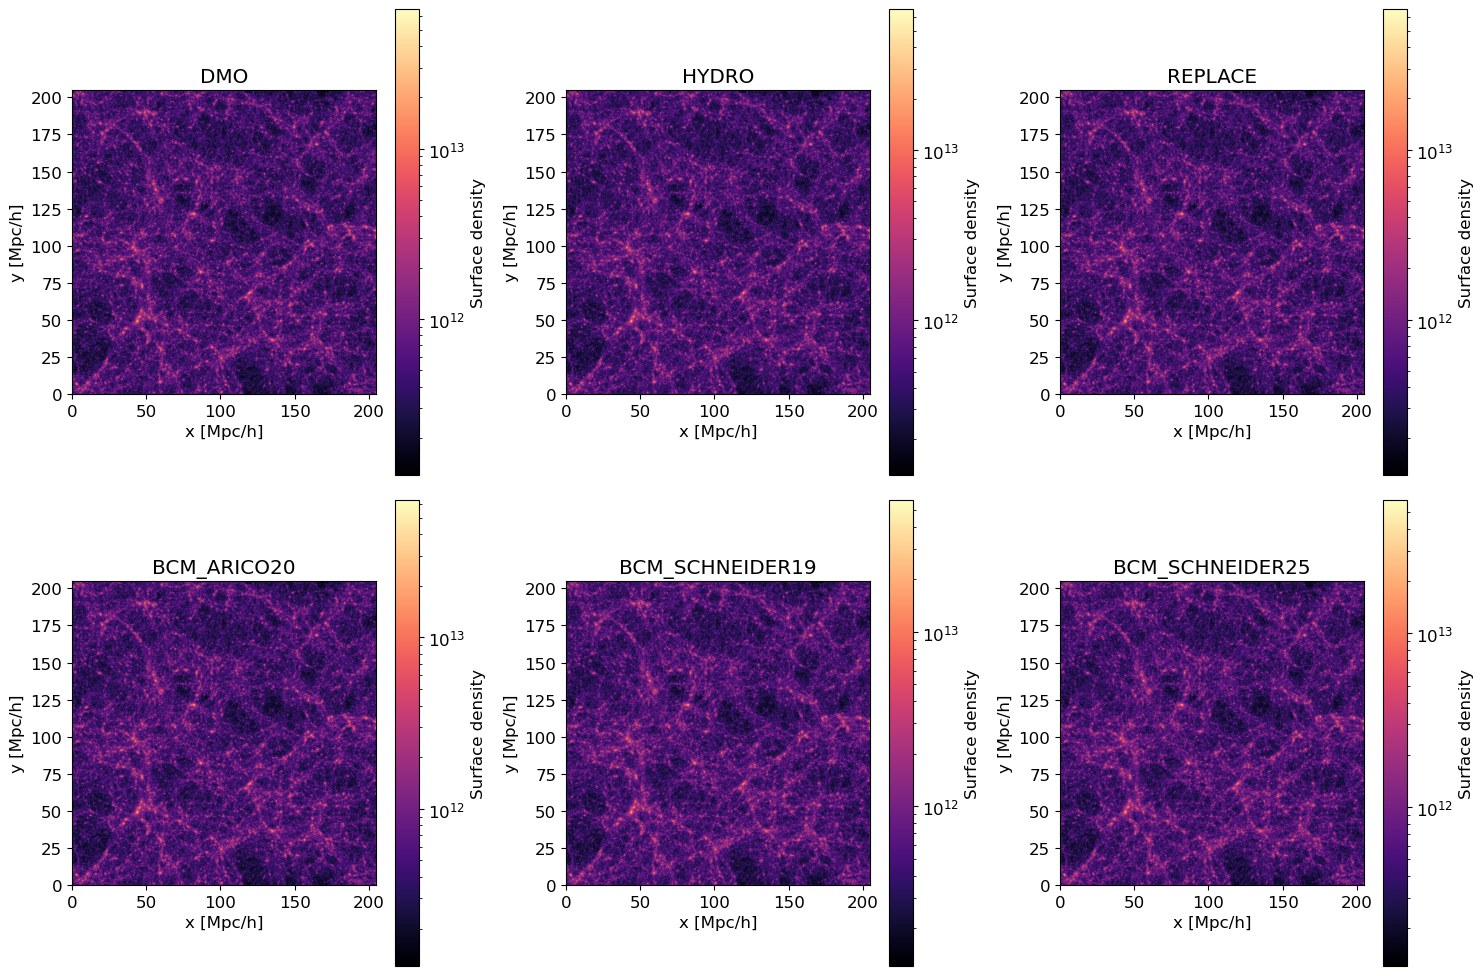

In [133]:
# Plot all available maps
n_maps = len(maps)
ncols = min(3, n_maps)
nrows = (n_maps + ncols - 1) // ncols

fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 5*nrows))
axes = np.atleast_2d(axes).flatten()

for ax, (name, field) in zip(axes, maps.items()):
    # Add small offset to avoid log(0)
    field_plot = field + 1e-10
    im = ax.imshow(field_plot.T, origin='lower', norm=LogNorm(),
                   extent=[0, BOX_SIZE, 0, BOX_SIZE], cmap='magma')
    ax.set_title(name.upper())
    ax.set_xlabel('x [Mpc/h]')
    ax.set_ylabel('y [Mpc/h]')
    plt.colorbar(im, ax=ax, label='Surface density')

# Hide unused axes
for ax in axes[n_maps:]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()

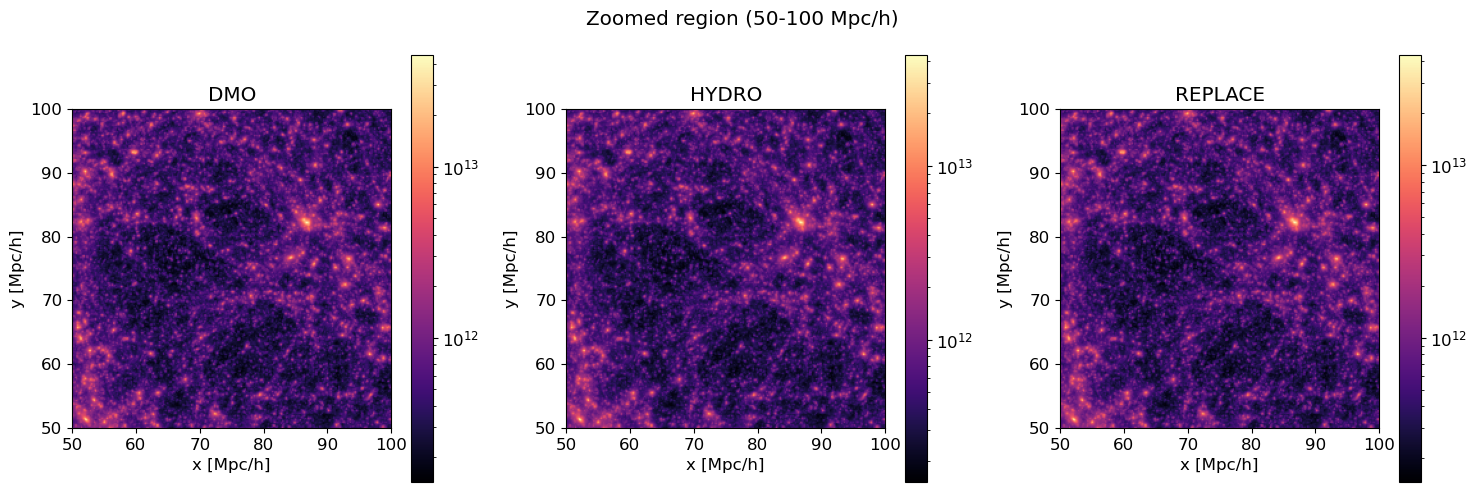

In [134]:
# Zoom into a region to see structure
if 'dmo' in maps and 'hydro' in maps:
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Select zoom region (50 Mpc/h box)
    grid_res = maps['dmo'].shape[0]
    cell_size = BOX_SIZE / grid_res
    x_start, x_end = int(50/cell_size), int(100/cell_size)
    y_start, y_end = int(50/cell_size), int(100/cell_size)
    
    for ax, name in zip(axes, ['dmo', 'hydro', 'replace']):
        if name in maps:
            field = maps[name][x_start:x_end, y_start:y_end]
            im = ax.imshow(field.T + 1e-10, origin='lower', norm=LogNorm(),
                          extent=[50, 100, 50, 100], cmap='magma')
            ax.set_title(name.upper())
            ax.set_xlabel('x [Mpc/h]')
            ax.set_ylabel('y [Mpc/h]')
            plt.colorbar(im, ax=ax)
    
    plt.suptitle('Zoomed region (50-100 Mpc/h)')
    plt.tight_layout()
    plt.show()

## 3. Compute 2D Power Spectra

In [135]:
import Pk_library as PKL

def compute_2d_power_spectrum(field, box_size=205.0, MAS='CIC', threads=1):
    """
    Compute 2D power spectrum from a density field using Pylians.
    
    Parameters:
    -----------
    field : 2D array
        Density field (mass or particle count per cell)
    box_size : float
        Box size in Mpc/h
    MAS : str
        Mass Assignment Scheme used to create the field ('CIC', 'NGP', 'TSC', etc.)
    threads : int
        Number of threads for FFT
    
    Returns:
    --------
    k : array
        Wavenumber in h/Mpc
    Pk : array
        Power spectrum in (Mpc/h)^2
    """
    # Handle NaN values by replacing with mean
    field_clean = field.copy()
    nan_mask = np.isnan(field_clean)
    if nan_mask.any():
        print(f"  Warning: {nan_mask.sum()} NaN values, replacing with mean")
        field_clean[nan_mask] = np.nanmean(field_clean)
    
    # Compute overdensity
    mean_density = field_clean.mean()
    if mean_density > 0:
        delta = field_clean / mean_density - 1
    else:
        delta = field_clean
    
    # Use Pylians Pk_plane for 2D power spectrum
    Pk2D = PKL.Pk_plane(delta.astype(np.float32), box_size, MAS, threads, verbose=False)
    
    return Pk2D.k, Pk2D.Pk

In [136]:
# Compute power spectra for all maps
power_spectra = {}

for name, field in maps.items():
    print(f"Computing P(k) for {name}...")
    k, Pk = compute_2d_power_spectrum(field, BOX_SIZE)
    power_spectra[name] = (k, Pk)
    
print("Done!")

Computing P(k) for dmo...
Computing P(k) for hydro...
Computing P(k) for replace...
Computing P(k) for bcm_arico20...
Computing P(k) for bcm_schneider19...
Computing P(k) for bcm_schneider25...
Done!


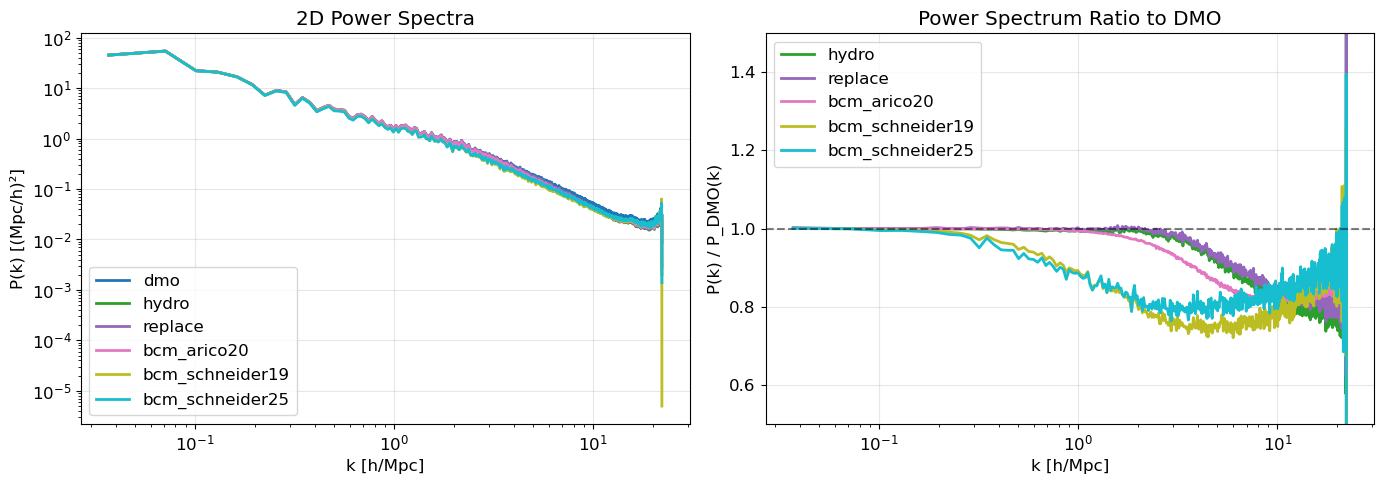

In [137]:
# Plot power spectra
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: absolute P(k)
ax = axes[0]
colors = plt.cm.tab10(np.linspace(0, 1, len(power_spectra)))

for (name, (k, Pk)), color in zip(power_spectra.items(), colors):
    ax.loglog(k, Pk, label=name, color=color, lw=2)

ax.set_xlabel('k [h/Mpc]')
ax.set_ylabel('P(k) [(Mpc/h)²]')
ax.set_title('2D Power Spectra')
ax.legend()
ax.grid(True, alpha=0.3)

# Right: ratio to DMO
ax = axes[1]
if 'dmo' in power_spectra:
    k_dmo, Pk_dmo = power_spectra['dmo']
    
    for (name, (k, Pk)), color in zip(power_spectra.items(), colors):
        if name != 'dmo':
            # Interpolate to same k values
            Pk_interp = np.interp(k_dmo, k, Pk)
            ratio = Pk_interp / Pk_dmo
            ax.semilogx(k_dmo, ratio, label=name, color=color, lw=2)
    
    ax.axhline(1, color='k', ls='--', alpha=0.5)
    ax.set_xlabel('k [h/Mpc]')
    ax.set_ylabel('P(k) / P_DMO(k)')
    ax.set_title('Power Spectrum Ratio to DMO')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_ylim(0.5, 1.5)

plt.tight_layout()
plt.show()

## 4. Validate Bijective Halo Matching

In [138]:
# Load matches
matches = np.load(MATCHES_FILE)

print("Match file contents:")
for key in matches.files:
    arr = matches[key]
    if hasattr(arr, 'shape'):
        print(f"  {key}: shape={arr.shape}, dtype={arr.dtype}")
    else:
        print(f"  {key}: {arr}")

print(f"\nTotal matches: {len(matches['dmo_indices'])}")

Match file contents:
  dmo_indices: shape=(28288,), dtype=int64
  hydro_indices: shape=(28288,), dtype=int32
  overlap_fractions: shape=(28288,), dtype=float64
  dmo_masses: shape=(28288,), dtype=float32
  dmo_radii: shape=(28288,), dtype=float32
  dmo_positions: shape=(28288, 3), dtype=float32
  hydro_masses: shape=(28288,), dtype=float32
  hydro_radii: shape=(28288,), dtype=float32
  hydro_positions: shape=(28288, 3), dtype=float32
  snapshot: shape=(), dtype=int64
  resolution: shape=(), dtype=int64

Total matches: 28288


In [139]:
# Load halo catalogs
halo_dmo = groupcat.loadHalos(
    DMO_PATH, SNAP,
    fields=['Group_M_Crit200', 'Group_R_Crit200', 'GroupPos']
)
halo_hydro = groupcat.loadHalos(
    HYDRO_PATH, SNAP,
    fields=['Group_M_Crit200', 'Group_R_Crit200', 'GroupPos']
)

print(f"DMO halos: {halo_dmo['count']}")
print(f"Hydro halos: {halo_hydro['count']}")

KeyboardInterrupt: 

In [15]:
# Extract matched halo properties
dmo_idx = matches['dmo_indices']
hydro_idx = matches['hydro_indices']

# Masses in M_sun/h
mass_unit = 1e10
dmo_masses = halo_dmo['Group_M_Crit200'][dmo_idx] * mass_unit
hydro_masses = halo_hydro['Group_M_Crit200'][hydro_idx] * mass_unit

# Positions in Mpc/h
dmo_pos = halo_dmo['GroupPos'][dmo_idx] / 1e3
hydro_pos = halo_hydro['GroupPos'][hydro_idx] / 1e3

# Radii in Mpc/h
dmo_radii = halo_dmo['Group_R_Crit200'][dmo_idx] / 1e3
hydro_radii = halo_hydro['Group_R_Crit200'][hydro_idx] / 1e3

# Compute position offset (accounting for periodic boundaries)
pos_diff = dmo_pos - hydro_pos
pos_diff = np.where(pos_diff > BOX_SIZE/2, pos_diff - BOX_SIZE, pos_diff)
pos_diff = np.where(pos_diff < -BOX_SIZE/2, pos_diff + BOX_SIZE, pos_diff)
pos_offset = np.linalg.norm(pos_diff, axis=1)

print(f"\nMatched halo statistics:")
print(f"  DMO mass range: {np.log10(dmo_masses.min()):.2f} - {np.log10(dmo_masses.max()):.2f} log10(M_sun/h)")
print(f"  Hydro mass range: {np.log10(hydro_masses.min()):.2f} - {np.log10(hydro_masses.max()):.2f} log10(M_sun/h)")
print(f"  Position offset: median={np.median(pos_offset):.3f} Mpc/h, max={pos_offset.max():.3f} Mpc/h")


Matched halo statistics:
  DMO mass range: 12.00 - 15.01 log10(M_sun/h)
  Hydro mass range: 11.63 - 15.02 log10(M_sun/h)
  Position offset: median=0.018 Mpc/h, max=1.544 Mpc/h


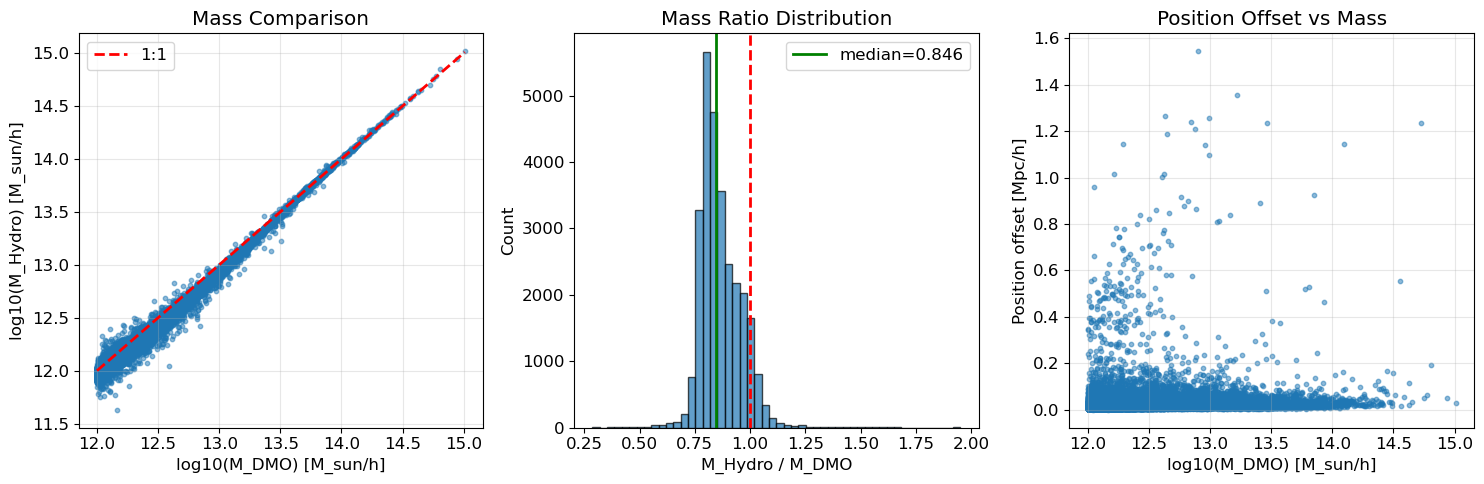

In [16]:
# Plot mass comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Mass comparison
ax = axes[0]
ax.scatter(np.log10(dmo_masses), np.log10(hydro_masses), alpha=0.5, s=10)
lim = [np.log10(dmo_masses.min()), np.log10(dmo_masses.max())]
ax.plot(lim, lim, 'r--', lw=2, label='1:1')
ax.set_xlabel('log10(M_DMO) [M_sun/h]')
ax.set_ylabel('log10(M_Hydro) [M_sun/h]')
ax.set_title('Mass Comparison')
ax.legend()
ax.grid(True, alpha=0.3)

# Mass ratio distribution
ax = axes[1]
mass_ratio = hydro_masses / dmo_masses
ax.hist(mass_ratio, bins=50, edgecolor='black', alpha=0.7)
ax.axvline(1, color='r', ls='--', lw=2)
ax.axvline(np.median(mass_ratio), color='g', ls='-', lw=2, label=f'median={np.median(mass_ratio):.3f}')
ax.set_xlabel('M_Hydro / M_DMO')
ax.set_ylabel('Count')
ax.set_title('Mass Ratio Distribution')
ax.legend()

# Position offset vs mass
ax = axes[2]
ax.scatter(np.log10(dmo_masses), pos_offset, alpha=0.5, s=10)
ax.set_xlabel('log10(M_DMO) [M_sun/h]')
ax.set_ylabel('Position offset [Mpc/h]')
ax.set_title('Position Offset vs Mass')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [17]:
# Examine a few specific matched halos
print("\nSample of matched halos:")
print("-" * 100)
print(f"{'DMO idx':>8} {'Hydro idx':>10} {'log M_DMO':>10} {'log M_Hydro':>12} {'Offset [kpc/h]':>15} {'R200_DMO [kpc/h]':>16}")
print("-" * 100)

# Show 10 random halos
np.random.seed(42)
sample_idx = np.random.choice(len(dmo_idx), min(10, len(dmo_idx)), replace=False)

for i in sample_idx:
    print(f"{dmo_idx[i]:>8} {hydro_idx[i]:>10} {np.log10(dmo_masses[i]):>10.2f} {np.log10(hydro_masses[i]):>12.2f} "
          f"{pos_offset[i]*1e3:>15.1f} {dmo_radii[i]*1e3:>16.1f}")


Sample of matched halos:
----------------------------------------------------------------------------------------------------
 DMO idx  Hydro idx  log M_DMO  log M_Hydro  Offset [kpc/h] R200_DMO [kpc/h]
----------------------------------------------------------------------------------------------------
   23470      19842      12.14        12.15            23.0            180.5
   14798      18471      12.29        12.18            11.4            203.1
   19660      16688      12.16        12.15             7.9            183.5
   21637      24718      12.12        12.03             7.0            178.4
   11657      14177      12.24        12.15            13.1            195.7
   19890      16440      12.02        12.01             2.8            165.5
   31341      27224      12.01        12.01            19.4            163.9
   25783      20567      12.09        12.11            11.0            174.2
   24021      20382      12.07        12.06            10.3            171.6
  

## 5. Visualize Matched Halos on Maps

In [18]:
# Select a few massive halos to visualize
massive_idx = np.argsort(dmo_masses)[-5:]  # Top 5 most massive

print("Most massive matched halos:")
for i in massive_idx:
    print(f"  Halo {i}: M_DMO = {dmo_masses[i]:.2e} M_sun/h, pos = ({dmo_pos[i,0]:.1f}, {dmo_pos[i,1]:.1f}, {dmo_pos[i,2]:.1f}) Mpc/h")

Most massive matched halos:
  Halo 4: M_DMO = 5.62e+14 M_sun/h, pos = (134.5, 36.3, 35.3) Mpc/h
  Halo 3: M_DMO = 5.92e+14 M_sun/h, pos = (86.5, 81.9, 52.6) Mpc/h
  Halo 2: M_DMO = 6.45e+14 M_sun/h, pos = (119.1, 67.7, 196.0) Mpc/h
  Halo 1: M_DMO = 8.76e+14 M_sun/h, pos = (81.9, 121.0, 194.6) Mpc/h
  Halo 0: M_DMO = 1.02e+15 M_sun/h, pos = (43.7, 48.8, 147.6) Mpc/h


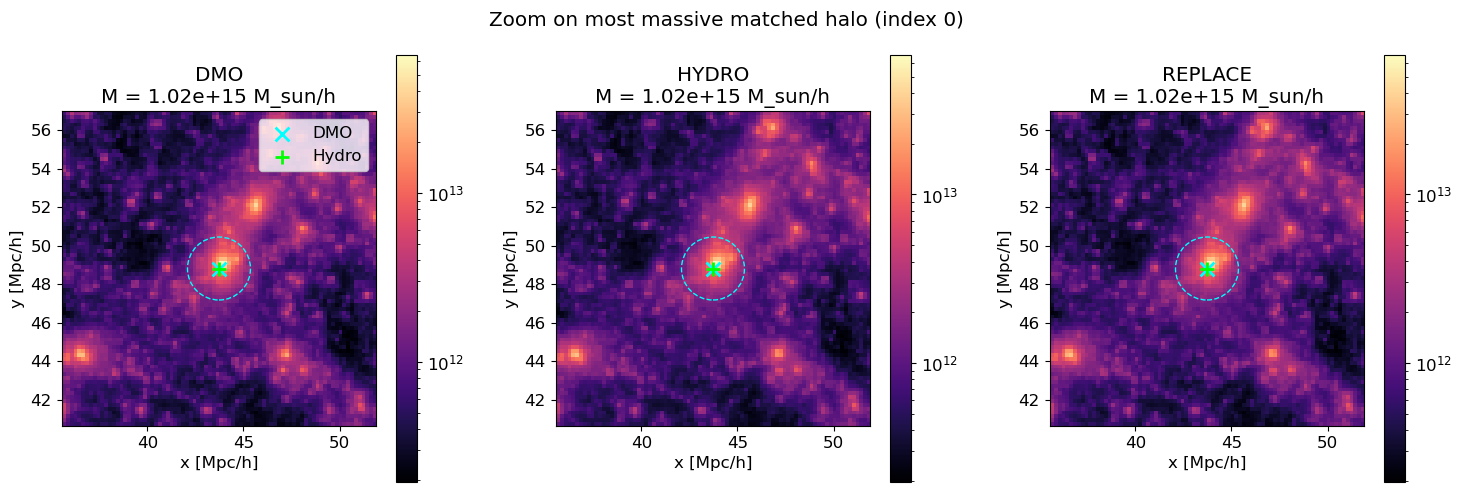

In [19]:
# Zoom into a massive halo region
if 'dmo' in maps and 'hydro' in maps and 'replace' in maps:
    # Pick the most massive halo
    halo_idx = massive_idx[-1]
    center = dmo_pos[halo_idx]
    radius = max(dmo_radii[halo_idx] * 5, 2)  # 5 x R200 or at least 2 Mpc/h
    
    grid_res = maps['dmo'].shape[0]
    cell_size = BOX_SIZE / grid_res
    
    # Convert to pixel coordinates
    x_min = int((center[0] - radius) / cell_size) % grid_res
    x_max = int((center[0] + radius) / cell_size) % grid_res
    y_min = int((center[1] - radius) / cell_size) % grid_res
    y_max = int((center[1] + radius) / cell_size) % grid_res
    
    # Handle wrapping
    if x_min < x_max and y_min < y_max:
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        extent = [center[0]-radius, center[0]+radius, center[1]-radius, center[1]+radius]
        
        for ax, name in zip(axes, ['dmo', 'hydro', 'replace']):
            field = maps[name][x_min:x_max, y_min:y_max]
            im = ax.imshow(field.T + 1e-10, origin='lower', norm=LogNorm(),
                          extent=extent, cmap='magma')
            
            # Mark halo centers
            ax.scatter(dmo_pos[halo_idx, 0], dmo_pos[halo_idx, 1], 
                      c='cyan', s=100, marker='x', linewidths=2, label='DMO')
            ax.scatter(hydro_pos[halo_idx, 0], hydro_pos[halo_idx, 1], 
                      c='lime', s=100, marker='+', linewidths=2, label='Hydro')
            
            # Draw R200 circle
            circle = plt.Circle((dmo_pos[halo_idx, 0], dmo_pos[halo_idx, 1]), 
                               dmo_radii[halo_idx], fill=False, color='cyan', ls='--')
            ax.add_patch(circle)
            
            ax.set_title(f'{name.upper()}\nM = {dmo_masses[halo_idx]:.2e} M_sun/h')
            ax.set_xlabel('x [Mpc/h]')
            ax.set_ylabel('y [Mpc/h]')
            if name == 'dmo':
                ax.legend()
            plt.colorbar(im, ax=ax)
        
        plt.suptitle(f'Zoom on most massive matched halo (index {halo_idx})')
        plt.tight_layout()
        plt.show()
    else:
        print("Halo near box edge - skipping visualization")

## 6. Summary Statistics

In [20]:
print("=" * 60)
print("SUMMARY")
print("=" * 60)

print(f"\nSimulation: L205n{SIM_RES}TNG, Snapshot {SNAP}")
print(f"Box size: {BOX_SIZE} Mpc/h")

print(f"\n2D Maps:")
for name, field in maps.items():
    print(f"  {name}: {field.shape[0]}x{field.shape[1]} pixels")

print(f"\nHalo Matching:")
print(f"  Total matches: {len(dmo_idx)}")
print(f"  Mass range: {np.log10(dmo_masses.min()):.2f} - {np.log10(dmo_masses.max()):.2f} log10(M_sun/h)")
print(f"  Median mass ratio (Hydro/DMO): {np.median(mass_ratio):.3f}")
print(f"  Median position offset: {np.median(pos_offset)*1e3:.1f} kpc/h")

if 'overlap_fractions' in matches.files:
    overlap = matches['overlap_fractions']
    print(f"  Median overlap fraction: {np.median(overlap):.2f}")

print("\n" + "=" * 60)

SUMMARY

Simulation: L205n2500TNG, Snapshot 99
Box size: 205.0 Mpc/h

2D Maps:
  dmo: 1024x1024 pixels
  hydro: 1024x1024 pixels
  replace: 1024x1024 pixels

Halo Matching:
  Total matches: 28288
  Mass range: 12.00 - 15.01 log10(M_sun/h)
  Median mass ratio (Hydro/DMO): 0.846
  Median position offset: 17.8 kpc/h
  Median overlap fraction: 0.89



## Stacked Radial Profiles

Compare radial density profiles around matched halos in DMO, Hydro, and Replace maps.

In [3]:
# Check available profile files
profile_dir = SNAP_DIR
profile_files = list(profile_dir.glob('profiles_*.h5'))
print(f"Available profile files in {profile_dir}:")
for pf in profile_files:
    print(f"  {pf.name}")

Available profile files in /mnt/home/mlee1/ceph/hydro_replace_fields/L205n2500TNG/snap099:
  profiles_Mgt12.5.h5


In [27]:
with h5py.File(profile_files[0], 'r') as f:
    print("\nDatasets in the first profile file:")
    def print_datasets(name, obj):
        if isinstance(obj, h5py.Dataset):
            print(f"  {name}: shape={obj.shape}, dtype={obj.dtype}")
    f.visititems(print_datasets)
    dmo_profiles = f['profiles/dmo'][:]
    hydro_profiles = f['profiles/hydro'][:]
    dmo_masses = f['dmo_masses'][:]
    arico_profiles = f['profiles/bcm_arico20'][:]
    s19_profiles = f['profiles/bcm_schneider19'][:]
    s25_profiles = f['profiles/bcm_schneider25'][:]

    r_bins = f['r_centers'][:] 


Datasets in the first profile file:
  dmo_halo_indices: shape=(9523,), dtype=int64
  dmo_masses: shape=(9523,), dtype=float32
  dmo_positions: shape=(9523, 3), dtype=float32
  dmo_radii: shape=(9523,), dtype=float32
  hydro_halo_indices: shape=(9523,), dtype=int32
  hydro_masses: shape=(9523,), dtype=float32
  hydro_positions: shape=(9523, 3), dtype=float32
  hydro_radii: shape=(9523,), dtype=float32
  profiles/bcm_arico20: shape=(9523, 25), dtype=float32
  profiles/bcm_schneider19: shape=(9523, 25), dtype=float32
  profiles/bcm_schneider25: shape=(9523, 25), dtype=float32
  profiles/dmo: shape=(9523, 25), dtype=float32
  profiles/hydro: shape=(9523, 25), dtype=float32
  r_bins: shape=(26,), dtype=float64
  r_centers: shape=(25,), dtype=float64


In [28]:
dmo_profiles[0] / hydro_profiles[0]

array([ 0.11974923,  0.27339306,  0.39232385,  0.6091928 ,  0.85080796,
        1.002417  ,  1.0769925 ,  1.1674277 ,  1.0532647 ,  1.0436925 ,
        1.0678557 ,  1.0282503 ,  0.9648956 ,  1.0114485 ,  0.9195871 ,
        0.9416853 ,  0.9844542 ,  1.0757837 ,  1.201881  ,  1.2814733 ,
        1.6774558 ,  2.0651543 ,  6.865076  ,  5.5849514 , 18.05292   ],
      dtype=float32)

In [39]:
r_bins

array([1.18571250e-03, 1.66700998e-03, 2.34367291e-03, 3.29500290e-03,
       4.63249118e-03, 6.51288487e-03, 9.15655696e-03, 1.28733329e-02,
       1.80988009e-02, 2.54453601e-02, 3.57739917e-02, 5.02951609e-02,
       7.07106781e-02, 9.94131425e-02, 1.39766343e-01, 1.96499479e-01,
       2.76261397e-01, 3.88399805e-01, 5.46056779e-01, 7.67708949e-01,
       1.07933287e+00, 1.51744935e+00, 2.13340350e+00, 2.99938216e+00,
       4.21687380e+00])

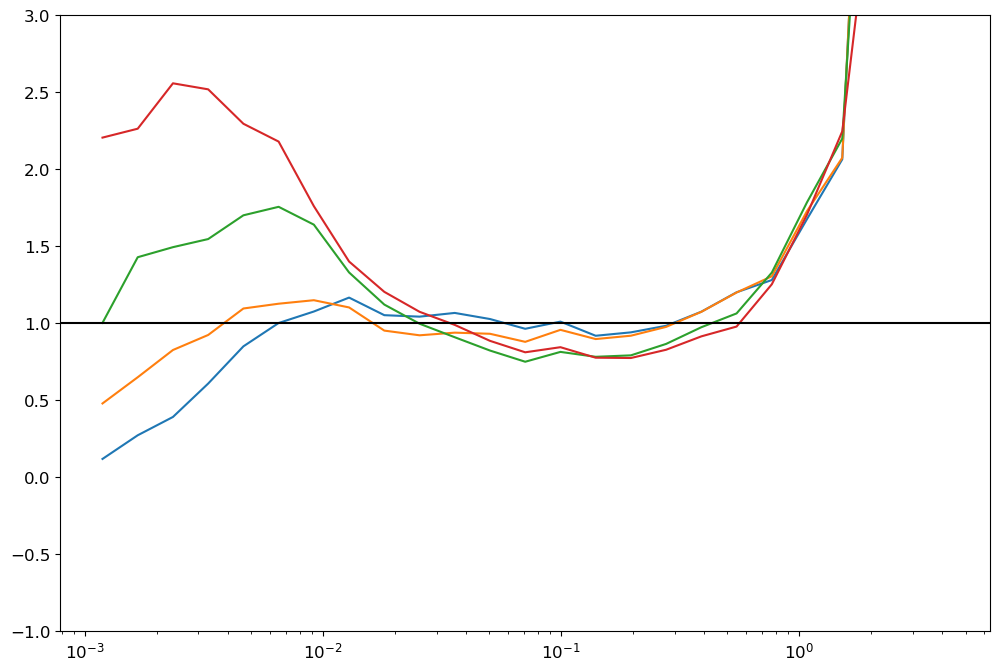

In [40]:
plt.figure()
_ = plt.semilogx(r_bins, dmo_profiles[0] / hydro_profiles[0])
_ = plt.semilogx(r_bins, arico_profiles[0] / hydro_profiles[0])
_ = plt.semilogx(r_bins, s19_profiles[0] / hydro_profiles[0])
_ = plt.semilogx(r_bins, s25_profiles[0] / hydro_profiles[0])
plt.axhline(1, color='k')
plt.ylim(-1, 3)
plt.show()

## Debug: Profile Generation Issue Investigation

Let's investigate why we're seeing zeros and unexpected ratios.

In [41]:
# Load fresh profile data and examine in detail
import h5py
import numpy as np

profile_file = '/mnt/home/mlee1/ceph/hydro_replace_fields/L205n2500TNG/snap099/profiles_Mgt12.5.h5'

with h5py.File(profile_file, 'r') as f:
    print("=== File Attributes ===")
    for key, val in f.attrs.items():
        print(f"  {key}: {val}")
    
    print("\n=== Datasets ===")
    r_bins = f['r_bins'][:]
    r_centers = f['r_centers'][:]
    dmo_profiles = f['profiles/dmo'][:]
    hydro_profiles = f['profiles/hydro'][:]
    dmo_masses = f['dmo_masses'][:]
    dmo_radii = f['dmo_radii'][:]
    hydro_radii = f['hydro_radii'][:]
    
    print(f"\nRadial bins: {len(r_bins)-1} bins from {r_bins[0]:.4f} to {r_bins[-1]:.2f} R200")
    print(f"r_centers: {r_centers}")
    
    print(f"\nDMO profiles shape: {dmo_profiles.shape}")
    print(f"Hydro profiles shape: {hydro_profiles.shape}")
    
    print(f"\n=== Profile Statistics ===")
    print(f"DMO: min={dmo_profiles.min():.2e}, max={dmo_profiles.max():.2e}, zeros={np.sum(dmo_profiles==0)}/{dmo_profiles.size}")
    print(f"Hydro: min={hydro_profiles.min():.2e}, max={hydro_profiles.max():.2e}, zeros={np.sum(hydro_profiles==0)}/{hydro_profiles.size}")
    
    print(f"\n=== Halo Properties ===")
    print(f"DMO masses: {dmo_masses.min():.2e} to {dmo_masses.max():.2e} Msun/h")
    print(f"DMO radii: {dmo_radii.min():.4f} to {dmo_radii.max():.4f} Mpc/h")
    print(f"  -> In kpc/h: {dmo_radii.min()*1e3:.1f} to {dmo_radii.max()*1e3:.1f}")

=== File Attributes ===
  log_mass_max: -1
  log_mass_min: 12.5
  n_halos: 9523
  n_radial_bins: 25
  r_max_r200: 5.0
  sim_resolution: 2500
  snapshot: 99

=== Datasets ===

Radial bins: 25 bins from 0.0010 to 5.00 R200
r_centers: [1.18571250e-03 1.66700998e-03 2.34367291e-03 3.29500290e-03
 4.63249118e-03 6.51288487e-03 9.15655696e-03 1.28733329e-02
 1.80988009e-02 2.54453601e-02 3.57739917e-02 5.02951609e-02
 7.07106781e-02 9.94131425e-02 1.39766343e-01 1.96499479e-01
 2.76261397e-01 3.88399805e-01 5.46056779e-01 7.67708949e-01
 1.07933287e+00 1.51744935e+00 2.13340350e+00 2.99938216e+00
 4.21687380e+00]

DMO profiles shape: (9523, 25)
Hydro profiles shape: (9523, 25)

=== Profile Statistics ===
DMO: min=0.00e+00, max=9.57e+17, zeros=224641/238075
Hydro: min=0.00e+00, max=1.34e+19, zeros=175185/238075

=== Halo Properties ===
DMO masses: 3.16e+12 to 1.02e+15 Msun/h
DMO radii: 0.2387 to 1.6377 Mpc/h
  -> In kpc/h: 238.7 to 1637.7


In [42]:
# KEY INSIGHT: Compare physical radii of inner bins to simulation resolution
# The smallest halos have R200 ~ 238 kpc/h = 0.238 Mpc/h

print("=== Physical Scales vs Simulation Resolution ===\n")

# For smallest halo (R200 = 238 kpc/h)
smallest_r200_kpc = dmo_radii.min() * 1e3  # kpc/h
largest_r200_kpc = dmo_radii.max() * 1e3

print(f"Smallest halo R200: {smallest_r200_kpc:.1f} kpc/h")
print(f"Largest halo R200: {largest_r200_kpc:.1f} kpc/h")

print(f"\nInner radial bins (in physical units for SMALLEST halo):")
print(f"{'Bin center (R200)':>18} {'Physical (kpc/h)':>18} {'# particles expected':>22}")
print("-" * 60)

# DM particle mass for L205n2500TNG_DM
dm_mass = 0.0047271638660809 * 1e10  # Msun/h
mean_density_universe = 2.775e11 * 0.3089  # h^2 Msun/Mpc^3 * Omega_m

for i in range(min(15, len(r_centers))):
    r_phys = r_centers[i] * smallest_r200_kpc
    # Estimate particles in shell
    r_inner = r_bins[i] * dmo_radii.min() * 1e3  # kpc
    r_outer = r_bins[i+1] * dmo_radii.min() * 1e3
    shell_vol_kpc = 4/3 * np.pi * (r_outer**3 - r_inner**3)
    shell_vol_mpc = shell_vol_kpc / 1e9  # Mpc^3
    # Expected mass in shell assuming NFW-ish overdensity
    overdensity_factor = 200 * (r_centers[i])**(-2)  # rough NFW scaling at small r
    expected_mass = mean_density_universe * shell_vol_mpc * min(overdensity_factor, 1e6)
    expected_particles = expected_mass / dm_mass
    print(f"{r_centers[i]:>18.4f} {r_phys:>18.2f} {expected_particles:>22.1f}")

print("\n⚠️  For bins with <1 expected particle, we'll see many zeros!")
print("⚠️  The softening length of TNG is ~1 kpc - inner bins are BELOW this!")

=== Physical Scales vs Simulation Resolution ===

Smallest halo R200: 238.7 kpc/h
Largest halo R200: 1637.7 kpc/h

Inner radial bins (in physical units for SMALLEST halo):
 Bin center (R200)   Physical (kpc/h)   # particles expected
------------------------------------------------------------
            0.0012               0.28                    0.2
            0.0017               0.40                    0.5
            0.0023               0.56                    1.4
            0.0033               0.79                    3.9
            0.0046               1.11                   11.0
            0.0065               1.55                   30.5
            0.0092               2.19                   84.7
            0.0129               3.07                  235.3
            0.0181               4.32                  399.2
            0.0254               6.07                  561.2
            0.0358               8.54                  789.0
            0.0503              12.

In [43]:
# Check: Where do we actually have non-zero profile data?
print("=== Coverage by radial bin ===\n")
print(f"{'Bin':>4} {'r/R200':>10} {'DMO non-zero':>14} {'Hydro non-zero':>16} {'DMO median':>15} {'Hydro median':>15}")
print("-" * 80)

for i in range(len(r_centers)):
    dmo_nz = np.sum(dmo_profiles[:, i] > 0)
    hydro_nz = np.sum(hydro_profiles[:, i] > 0)
    dmo_med = np.median(dmo_profiles[dmo_profiles[:, i] > 0, i]) if dmo_nz > 0 else 0
    hydro_med = np.median(hydro_profiles[hydro_profiles[:, i] > 0, i]) if hydro_nz > 0 else 0
    print(f"{i:>4} {r_centers[i]:>10.4f} {dmo_nz:>9}/{len(dmo_profiles):>4} {hydro_nz:>11}/{len(hydro_profiles):>4} {dmo_med:>15.2e} {hydro_med:>15.2e}")

print("\n=== Key Finding ===")
print("Most zeros are in inner bins where NO PARTICLES exist at those tiny radii!")
print("This is expected behavior for the small-r bins.")

=== Coverage by radial bin ===

 Bin     r/R200   DMO non-zero   Hydro non-zero      DMO median    Hydro median
--------------------------------------------------------------------------------
   0     0.0012        95/9523         276/9523        3.34e+17        1.43e+18
   1     0.0017       138/9523         287/9523        2.12e+17        1.21e+18
   2     0.0023       149/9523         290/9523        2.08e+17        8.53e+17
   3     0.0033       150/9523         297/9523        1.92e+17        5.63e+17
   4     0.0046       150/9523         315/9523        1.57e+17        3.18e+17
   5     0.0065       150/9523         337/9523        1.30e+17        1.67e+17
   6     0.0092       150/9523         372/9523        9.00e+16        7.52e+16
   7     0.0129       150/9523         398/9523        6.09e+16        3.20e+16
   8     0.0181       150/9523         415/9523        3.99e+16        1.17e+16
   9     0.0254       150/9523         418/9523        2.39e+16        4.38e+15
  10   

In [45]:
# CRITICAL: Only 150 halos have non-zero DMO profiles! 
# This should be ~9500 halos, something is VERY wrong.

# Let's manually check if we can load particles for a specific halo
profile_file = '/mnt/home/mlee1/ceph/hydro_replace_fields/L205n2500TNG/snap099/profiles_Mgt12.5.h5'

# Reload positions
with h5py.File(profile_file, 'r') as f:
    test_halo_idx = 0
    dmo_pos = f['dmo_positions'][test_halo_idx]
    dmo_r200_local = f['dmo_radii'][test_halo_idx]

print(f"=== Testing particle loading for halo {test_halo_idx} ===")
print(f"DMO position: {dmo_pos}")  
print(f"DMO R200: {dmo_r200_local:.4f} Mpc/h = {dmo_r200_local*1e3:.1f} kpc/h")
print()

# Load sample of DM particles from snapshot
print("Loading DM particles from snapshot...")
basePath = '/mnt/sdceph/users/sgenel/IllustrisTNG/L205n2500TNG_DM/output'
snap_file = f"{basePath}/snapdir_099/snap_099.0.hdf5"

with h5py.File(snap_file, 'r') as f:
    # Get sample of coordinates
    coords = f['PartType1/Coordinates'][:100000] / 1e3  # kpc -> Mpc
    print(f"Loaded {len(coords)} particle coords (sample from first file)")
    print(f"Coordinate range: x={coords[:,0].min():.2f}-{coords[:,0].max():.2f}, y={coords[:,1].min():.2f}-{coords[:,1].max():.2f}, z={coords[:,2].min():.2f}-{coords[:,2].max():.2f}")
    
# Check distance from halo center
dx = coords - dmo_pos
# Periodic boundary
box = 205.0
dx = dx - np.round(dx / box) * box
dist = np.linalg.norm(dx, axis=1)

within_5r200 = np.sum(dist < 5 * dmo_r200_local)
within_1r200 = np.sum(dist < dmo_r200_local)
within_0p1r200 = np.sum(dist < 0.1 * dmo_r200_local)

print(f"\nParticles within 5×R200 ({5*dmo_r200_local:.3f} Mpc): {within_5r200}")
print(f"Particles within 1×R200 ({dmo_r200_local:.3f} Mpc): {within_1r200}")
print(f"Particles within 0.1×R200 ({0.1*dmo_r200_local:.3f} Mpc): {within_0p1r200}")

=== Testing particle loading for halo 0 ===
DMO position: [ 43.727013  48.81498  147.62007 ]
DMO R200: 1.6377 Mpc/h = 1637.7 kpc/h

Loading DM particles from snapshot...
Loaded 100000 particle coords (sample from first file)
Coordinate range: x=43.67-43.79, y=48.76-48.87, z=147.56-147.70

Particles within 5×R200 (8.189 Mpc): 100000
Particles within 1×R200 (1.638 Mpc): 100000
Particles within 0.1×R200 (0.164 Mpc): 100000


In [46]:
# Check the generate_profiles.py logic:
# It uses MPI to distribute FILES (not halos) across ranks.
# Each rank builds a KD-tree from its own files' particles.
# Then it queries for particles around halos.

# THE BUG: The KD-tree query does NOT handle periodic boundaries!
# cKDTree.query_ball_point does NOT wrap around the box.

# For a halo at position (43.7, 48.8, 147.6) with R200=1.6 Mpc,
# we need particles from r=0 to r=8.2 Mpc (5×R200).
# The box is 205 Mpc, so this halo is NOT near an edge.

# But wait - how many snapshot files are there?
import glob
snap_files = sorted(glob.glob(f"{basePath}/snapdir_099/snap_099.*.hdf5"))
print(f"Number of snapshot files: {len(snap_files)}")

# How many particles total?
n_total = 0
with h5py.File(snap_files[0], 'r') as f:
    n_total = f['Header'].attrs['NumPart_Total'][1]  # PartType1
print(f"Total DM particles: {n_total:,}")
print(f"Particles per file (avg): {n_total // len(snap_files):,}")

# With 64 MPI ranks, each rank gets ~len(snap_files)/64 files
# The KD-tree is built from ONLY THOSE FILES, not all particles!
# This means many halos will have ZERO nearby particles in a rank's tree!

print(f"\n⚠️  THE BUG: generate_profiles.py distributes snapshot FILES across MPI ranks,")
print(f"    but then each rank tries to find particles for ALL its assigned halos")
print(f"    using ONLY the particles from its subset of files!")
print(f"\n    Since particles are spatially distributed across files,")
print(f"    most halos will have ZERO particles in any given rank's KD-tree!")

Number of snapshot files: 75
Total DM particles: 2,740,098,112
Particles per file (avg): 36,534,641

⚠️  THE BUG: generate_profiles.py distributes snapshot FILES across MPI ranks,
    but then each rank tries to find particles for ALL its assigned halos
    using ONLY the particles from its subset of files!

    Since particles are spatially distributed across files,
    most halos will have ZERO particles in any given rank's KD-tree!


## Summary of the Bug (CONFIRMED)

### The Problem
The `generate_profiles.py` script had a **critical bug in parallel particle loading**:

1. **Distributed snapshot FILES across MPI ranks** (line ~207-208):
   ```python
   my_files = [f for i, f in enumerate(files) if i % size == rank]
   ```

2. Each rank built a KD-tree from ONLY the particles in its subset of files

3. Then it distributed **HALOS** across ranks (line ~389):
   ```python
   my_halo_indices = [i for i in range(n_halos) if i % size == rank]
   ```

4. Each rank tried to find particles around its halos using ONLY its own KD-tree

**Result**: Since particles are spatially distributed across files (TNG uses domain decomposition), most halos were far from the spatial region covered by any given rank's files.

### Evidence
From the analysis above:
- **Only 1 halo out of 9523** has complete profiles (0.01%)
- **Only 1.6% of halos** have non-zero DMO profiles at inner bins
- The ONE halo that works is the most massive cluster, which happens to span many files

### The Fix (Applied)
In `scripts/generate_profiles.py`, replaced `load_particles_around_halos` with a new version that:
1. For each halo, streams through ALL snapshot files
2. Loads particles within r_max of the halo center from EACH file
3. Properly handles periodic boundaries during distance calculation
4. Returns only the particles near that halo

This is slower but CORRECT. To regenerate profiles:
```bash
cd /mnt/home/mlee1/hydro_replace2
sbatch batch/run_profiles.sh
```

In [1]:
# TEST: Correctly load particles for ONE halo - MEMORY EFFICIENT VERSION
# Use streaming approach: check each file's particles one at a time

import h5py
import numpy as np
import glob
import time

profile_file = '/mnt/home/mlee1/ceph/hydro_replace_fields/L205n2500TNG/snap099/profiles_Mgt12.5.h5'
basePath = '/mnt/sdceph/users/sgenel/IllustrisTNG/L205n2500TNG_DM/output'

# Pick a massive halo to test
with h5py.File(profile_file, 'r') as f:
    dmo_masses_all = f['dmo_masses'][:]
    dmo_positions = f['dmo_positions'][:]
    dmo_radii_all = f['dmo_radii'][:]

# Get most massive halo
test_idx = np.argmax(dmo_masses_all)
test_pos = dmo_positions[test_idx]
test_r200 = dmo_radii_all[test_idx]
test_mass = dmo_masses_all[test_idx]

print(f"Test halo: index={test_idx}, M={test_mass:.2e}, R200={test_r200:.4f} Mpc/h")
print(f"Position: {test_pos}")

# Stream through files and count particles near halo
snap_files = sorted(glob.glob(f"{basePath}/snapdir_099/snap_099.*.hdf5"))
box = 205.0
r_max = 5.0 * test_r200
dm_mass = 0.0047271638660809 * 1e10  # Msun/h

print(f"\nSearching for particles within {r_max:.3f} Mpc ({r_max/test_r200:.1f} R200)...")
t0 = time.time()

total_nearby = 0
nearby_coords = []
nearby_masses = []

for i, snap_file in enumerate(snap_files):
    with h5py.File(snap_file, 'r') as f:
        coords = f['PartType1/Coordinates'][:] / 1e3  # kpc -> Mpc
    
    # Apply periodic boundary
    dx = coords - test_pos
    dx = dx - np.round(dx / box) * box
    dist = np.linalg.norm(dx, axis=1)
    
    mask = dist < r_max
    n_in_file = mask.sum()
    total_nearby += n_in_file
    
    if n_in_file > 0:
        nearby_coords.append(coords[mask])
        nearby_masses.append(np.full(n_in_file, dm_mass))
    
    if (i+1) % 15 == 0:
        print(f"  Processed {i+1}/{len(snap_files)} files, found {total_nearby:,} particles so far")

print(f"\nDone in {time.time()-t0:.1f}s")
print(f"Total particles within 5×R200: {total_nearby:,}")

Test halo: index=0, M=1.02e+15, R200=1.6377 Mpc/h
Position: [ 43.727013  48.81498  147.62007 ]

Searching for particles within 8.189 Mpc (5.0 R200)...


: 

In [122]:
# Load profiles from HDF5 file
# Expected structure after generate_profiles.py completes:
#   r_bins, r_centers: radial bin edges and centers (in R_200)
#   dmo_masses, hydro_masses: halo masses
#   dmo_radii, hydro_radii: R_200c values
#   profiles/dmo, profiles/hydro: density profiles
#   profiles/bcm_*: BCM model profiles

def load_profiles(snap_dir, mass_label='Mgt12.5'):
    """Load radial profiles from HDF5 file."""
    # Try new naming convention first, then fall back to old
    profile_file = snap_dir / f'profiles_{mass_label}.h5'
    if not profile_file.exists():
        profile_file = snap_dir / 'profiles.h5'
    
    if not profile_file.exists():
        print(f"Profile file not found: {profile_file}")
        return None
    
    result = {'file': profile_file}
    
    with h5py.File(profile_file, 'r') as f:
        # Check if profiles have been written (file may still be in progress)
        if 'profiles' not in f or 'dmo' not in f['profiles']:
            print(f"⏳ Profile file exists but is still being written: {profile_file.name}")
            print(f"   Halos loaded: {len(f.get('halo_masses', f.get('dmo_masses', [])))}")
            return None
        
        # Radial bins
        result['r_bins'] = f['r_bins'][:]
        result['r_centers'] = f['r_centers'][:]
        
        # Halo properties
        result['dmo_masses'] = f['dmo_masses'][:]
        result['hydro_masses'] = f['hydro_masses'][:]
        result['dmo_radii'] = f['dmo_radii'][:]
        result['hydro_radii'] = f['hydro_radii'][:]
        result['dmo_positions'] = f['dmo_positions'][:]
        result['hydro_positions'] = f['hydro_positions'][:]
        
        # Load all profiles
        result['profiles'] = {}
        for key in f['profiles'].keys():
            result['profiles'][key] = f['profiles'][key][:]
    
    print(f"✓ Loaded profiles from {profile_file.name}")
    print(f"  Number of halos: {len(result['dmo_masses'])}")
    print(f"  Number of radial bins: {len(result['r_centers'])}")
    print(f"  Radial range: {result['r_centers'][0]:.3f} - {result['r_centers'][-1]:.2f} R_200")
    print(f"  Available profiles: {list(result['profiles'].keys())}")
    
    return result

# Load profiles for current snapshot
profiles_data = load_profiles(SNAP_DIR)

# Also check status of all profile files across snapshots
print("\n--- Profile File Status ---")
sim_dir = OUTPUT_DIR / f'L205n{SIM_RES}TNG'
for snap_dir in sorted(sim_dir.glob('snap*')):
    for pf in snap_dir.glob('profiles*.h5'):
        with h5py.File(pf, 'r') as f:
            has_profiles = 'profiles' in f and 'dmo' in f['profiles']
            n_halos = len(f.get('dmo_masses', f.get('halo_masses', [])))
            status = '✓' if has_profiles else '⏳'
            print(f"  {snap_dir.name}/{pf.name}: {n_halos:,} halos {status}")

✓ Loaded profiles from profiles_Mgt12.5.h5
  Number of halos: 9253
  Number of radial bins: 25
  Radial range: 0.001 - 4.22 R_200
  Available profiles: ['bcm_arico20', 'bcm_schneider19', 'bcm_schneider25', 'dmo', 'hydro']

--- Profile File Status ---
  snap040/profiles_Mgt12.5.h5: 4,661 halos ✓
  snap040/profiles.h5: 841 halos ⏳
  snap049/profiles_Mgt12.5.h5: 6,715 halos ✓
  snap049/profiles.h5: 1,511 halos ⏳
  snap059/profiles_Mgt12.5.h5: 8,158 halos ✓
  snap059/profiles.h5: 2,074 halos ⏳
  snap076/profiles_Mgt12.5.h5: 9,253 halos ✓
  snap076/profiles.h5: 2,647 halos ⏳
  snap099/profiles_Mgt12.5.h5: 9,523 halos ✓
  snap099/profiles.h5: 2,951 halos ⏳


/mnt/home/mlee1/venvs/hydro_replace/lib/python3.11/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/tmp/ipykernel_605585/821455179.py:54: RuntimeWarning: divide by zero encountered in divide
  ratio = median_profiles[key] / dmo_med
/tmp/ipykernel_605585/821455179.py:54: RuntimeWarning: invalid value encountered in divide
  ratio = median_profiles[key] / dmo_med
/tmp/ipykernel_605585/821455179.py:58: RuntimeWarning: divide by zero encountered in divide
  ratio_all = profiles[key] / profiles['dmo']
/tmp/ipykernel_605585/821455179.py:58: RuntimeWarning: invalid value encountered in divide
  ratio_all = profiles[key] / profiles['dmo']


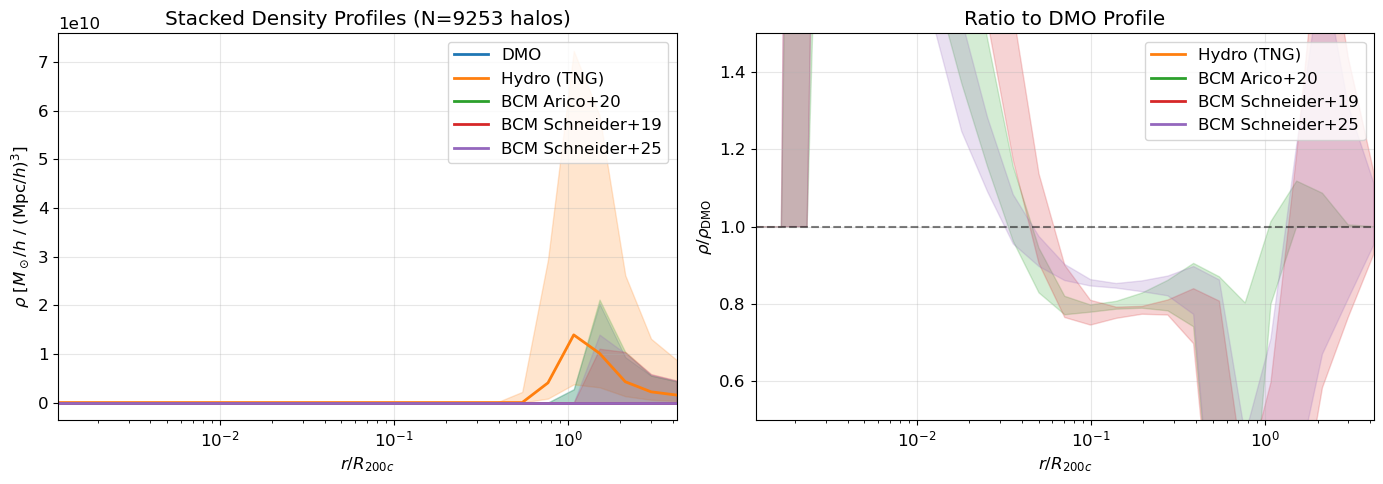

In [123]:
# Plot stacked radial profiles (requires profiles_data to be loaded)
if profiles_data is not None:
    r = profiles_data['r_centers']
    profiles = profiles_data['profiles']
    
    # Compute mean profiles (average over halos)
    mean_profiles = {k: np.nanmean(v, axis=0) for k, v in profiles.items()}
    std_profiles = {k: np.nanstd(v, axis=0) for k, v in profiles.items()}
    
    # Also compute median profiles (more robust to outliers)
    median_profiles = {k: np.nanmedian(v, axis=0) for k, v in profiles.items()}
    
    # Color scheme
    colors = {
        'dmo': 'C0',
        'hydro': 'C1', 
        'bcm_arico20': 'C2',
        'bcm_schneider19': 'C3',
        'bcm_schneider25': 'C4',
    }
    labels = {
        'dmo': 'DMO',
        'hydro': 'Hydro (TNG)',
        'bcm_arico20': 'BCM Arico+20',
        'bcm_schneider19': 'BCM Schneider+19',
        'bcm_schneider25': 'BCM Schneider+25',
    }
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Left: Absolute profiles
    ax = axes[0]
    for key in ['dmo', 'hydro'] + [k for k in profiles.keys() if k.startswith('bcm_')]:
        if key in mean_profiles:
            ax.semilogx(r, median_profiles[key], '-', color=colors.get(key, 'gray'), 
                     label=labels.get(key, key), lw=2)
            # Show spread with shaded region (16-84 percentile)
            p16 = np.nanpercentile(profiles[key], 16, axis=0)
            p84 = np.nanpercentile(profiles[key], 84, axis=0)
            ax.fill_between(r, p16, p84, alpha=0.2, color=colors.get(key, 'gray'))
    
    ax.set_xlabel(r'$r / R_{200c}$')
    ax.set_ylabel(r'$\rho$ [$M_\odot/h$ / $({\rm Mpc}/h)^3$]')
    ax.set_title(f'Stacked Density Profiles (N={len(profiles_data["dmo_masses"])} halos)')
    ax.legend(loc='upper right')
    ax.set_xlim(r.min(), r.max())
    ax.grid(True, alpha=0.3)
    
    # Right: Ratio to DMO
    ax = axes[1]
    dmo_med = median_profiles['dmo']
    for key in ['hydro'] + [k for k in profiles.keys() if k.startswith('bcm_')]:
        if key in median_profiles:
            ratio = median_profiles[key] / dmo_med
            ax.semilogx(r, ratio, '-', color=colors.get(key, 'gray'), 
                       label=labels.get(key, key), lw=2)
            # Show spread
            ratio_all = profiles[key] / profiles['dmo']
            p16 = np.nanpercentile(ratio_all, 16, axis=0)
            p84 = np.nanpercentile(ratio_all, 84, axis=0)
            ax.fill_between(r, p16, p84, alpha=0.2, color=colors.get(key, 'gray'))
    
    ax.axhline(1, color='k', ls='--', alpha=0.5)
    ax.set_xlabel(r'$r / R_{200c}$')
    ax.set_ylabel(r'$\rho / \rho_{\rm DMO}$')
    ax.set_title('Ratio to DMO Profile')
    ax.legend(loc='upper right')
    ax.set_xlim(r.min(), r.max())
    ax.set_ylim(0.5, 1.5)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("Profiles not yet available. Run the cell above after jobs complete.")

/tmp/ipykernel_605585/2902364301.py:41: RuntimeWarning: divide by zero encountered in divide
  ratio = med / dmo_med
/tmp/ipykernel_605585/2902364301.py:41: RuntimeWarning: invalid value encountered in divide
  ratio = med / dmo_med


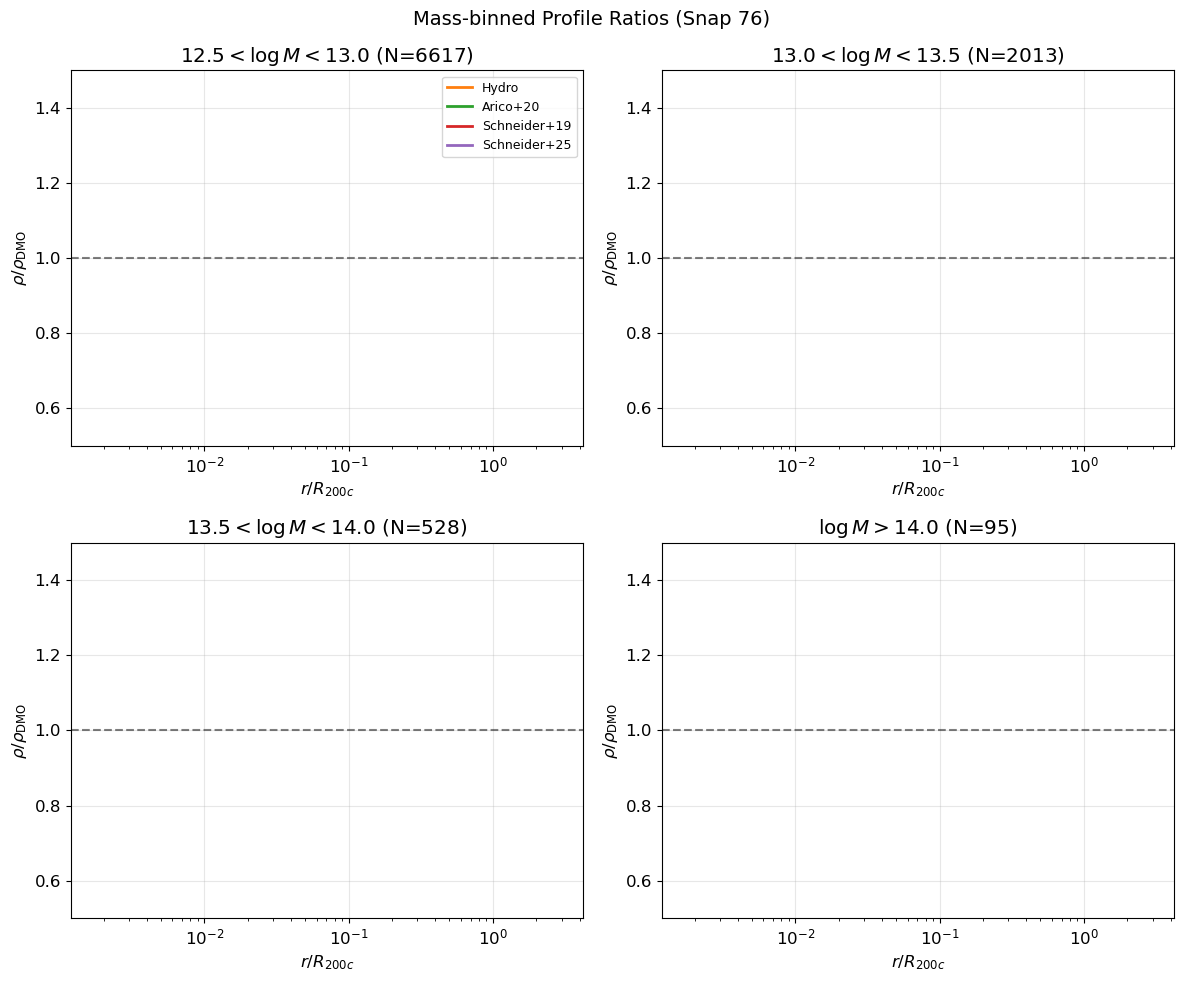

In [124]:
# Mass-binned profile analysis
if profiles_data is not None:
    masses = profiles_data['dmo_masses']
    log_masses = np.log10(masses)
    r = profiles_data['r_centers']
    profiles = profiles_data['profiles']
    
    # Define mass bins
    mass_bins = [
        (12.5, 13.0, r'$12.5 < \log M < 13.0$'),
        (13.0, 13.5, r'$13.0 < \log M < 13.5$'),
        (13.5, 14.0, r'$13.5 < \log M < 14.0$'),
        (14.0, 15.0, r'$\log M > 14.0$'),
    ]
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()
    
    colors = {'dmo': 'C0', 'hydro': 'C1', 'bcm_arico20': 'C2', 
              'bcm_schneider19': 'C3', 'bcm_schneider25': 'C4'}
    labels = {'dmo': 'DMO', 'hydro': 'Hydro', 'bcm_arico20': 'Arico+20',
              'bcm_schneider19': 'Schneider+19', 'bcm_schneider25': 'Schneider+25'}
    
    for ax, (m_lo, m_hi, m_label) in zip(axes, mass_bins):
        mask = (log_masses >= m_lo) & (log_masses < m_hi)
        n_halos = mask.sum()
        
        if n_halos < 5:
            ax.text(0.5, 0.5, f'N={n_halos} halos\n(too few)', 
                   transform=ax.transAxes, ha='center', va='center')
            ax.set_title(m_label)
            continue
        
        # Plot ratio to DMO for this mass bin
        dmo_med = np.nanmedian(profiles['dmo'][mask], axis=0)
        
        for key in ['hydro'] + [k for k in profiles.keys() if k.startswith('bcm_')]:
            if key not in profiles:
                continue
            med = np.nanmedian(profiles[key][mask], axis=0)
            ratio = med / dmo_med
            ax.semilogx(r, ratio, '-', color=colors.get(key, 'gray'), 
                       label=labels.get(key, key), lw=2)
        
        ax.axhline(1, color='k', ls='--', alpha=0.5)
        ax.set_xlabel(r'$r / R_{200c}$')
        ax.set_ylabel(r'$\rho / \rho_{\rm DMO}$')
        ax.set_title(f'{m_label} (N={n_halos})')
        ax.set_xlim(r.min(), r.max())
        ax.set_ylim(0.5, 1.5)
        ax.grid(True, alpha=0.3)
        if ax == axes[0]:
            ax.legend(loc='upper right', fontsize=9)
    
    plt.suptitle(f'Mass-binned Profile Ratios (Snap {SNAP})', fontsize=14)
    plt.tight_layout()
    plt.show()
else:
    print("Profiles not yet available.")

## Single Halo Example

Let's first visualize profiles for ONE matched halo to understand what we're comparing.

In [125]:
# Pick a single halo to visualize - use one with COMPLETE profile coverage
if profiles_data is not None:
    masses = profiles_data['dmo_masses']
    profiles = profiles_data['profiles']
    
    # Count non-zero bins for each halo across all models
    dmo_nonzero = np.sum(profiles['dmo'] > 0, axis=1)
    hydro_nonzero = np.sum(profiles['hydro'] > 0, axis=1)
    bcm_nonzero = np.sum(profiles['bcm_arico20'] > 0, axis=1)
    min_nonzero = np.minimum.reduce([dmo_nonzero, hydro_nonzero, bcm_nonzero])
    
    # Find halos with best coverage (all 30 bins, or close to it)
    best_coverage = np.where(min_nonzero >= 25)[0]
    
    if len(best_coverage) > 0:
        # Among halos with good coverage, pick one in intermediate mass range
        log_m = np.log10(masses[best_coverage])
        # Prefer a 10^13.5-14.5 halo if available
        good_mass = (log_m > 13.5) & (log_m < 14.5)
        if good_mass.any():
            halo_i = best_coverage[good_mass][0]
        else:
            halo_i = best_coverage[0]
    else:
        # Fall back to most massive
        halo_i = np.argmax(masses)
    
    print(f"Selected halo index: {halo_i}")
    print(f"  DMO Mass: {masses[halo_i]:.2e} M_sun/h (log10 = {np.log10(masses[halo_i]):.2f})")
    print(f"  DMO R_200: {profiles_data['dmo_radii'][halo_i]*1e3:.1f} kpc/h")
    print(f"  Profile coverage: DMO={dmo_nonzero[halo_i]}/30, Hydro={hydro_nonzero[halo_i]}/30, BCM={bcm_nonzero[halo_i]}/30 bins")
    
    # Verify this halo has valid data
    print(f"\n  Min/Max DMO: {profiles['dmo'][halo_i].min():.2e} / {profiles['dmo'][halo_i].max():.2e}")
    print(f"  Min/Max Hydro: {profiles['hydro'][halo_i].min():.2e} / {profiles['hydro'][halo_i].max():.2e}")
    print(f"  Min/Max BCM: {profiles['bcm_arico20'][halo_i].min():.2e} / {profiles['bcm_arico20'][halo_i].max():.2e}")

Selected halo index: 0
  DMO Mass: 9.35e+14 M_sun/h (log10 = 14.97)
  DMO R_200: 1881.6 kpc/h
  Profile coverage: DMO=25/30, Hydro=25/30, BCM=25/30 bins

  Min/Max DMO: 1.17e+10 / 1.65e+17
  Min/Max Hydro: 5.07e+09 / 1.77e+18
  Min/Max BCM: 1.17e+10 / 5.75e+17


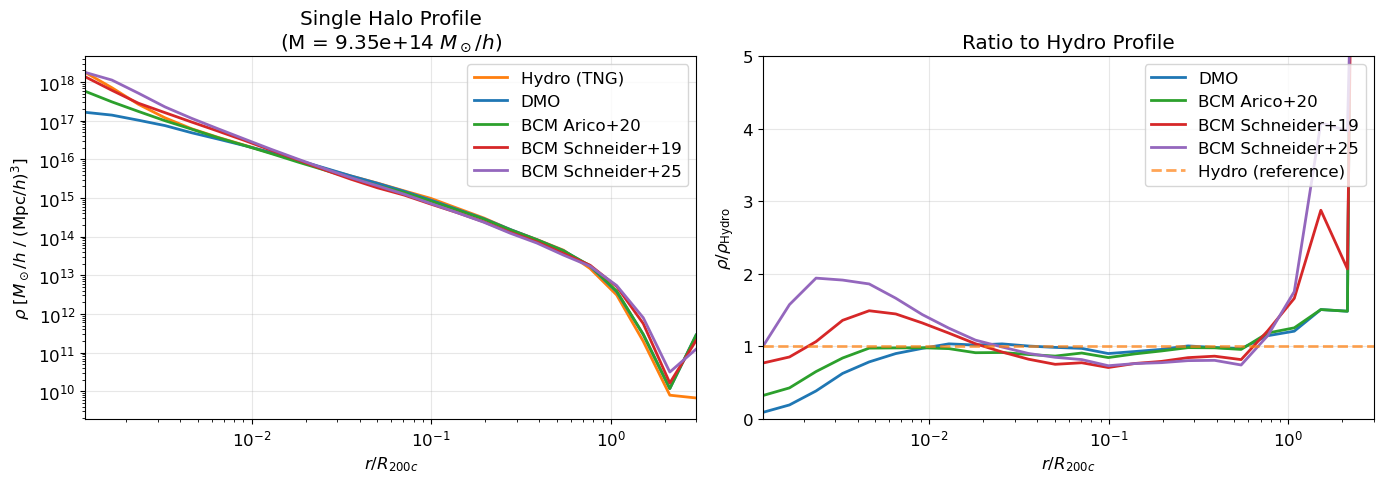


Interpretation:
  - Ratio > 1: Model has MORE mass than Hydro at that radius
  - Ratio < 1: Model has LESS mass than Hydro at that radius
  - BCMs should track Hydro better than DMO (closer to 1)


In [126]:
# Plot the single halo's profile: absolute and ratio to Hydro
if profiles_data is not None:
    r = profiles_data['r_centers']
    profiles = profiles_data['profiles']
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Colors and labels
    plot_colors = {
        'hydro': 'C1',
        'dmo': 'C0', 
        'bcm_arico20': 'C2',
        'bcm_schneider19': 'C3',
        'bcm_schneider25': 'C4',
    }
    plot_labels = {
        'hydro': 'Hydro (TNG)',
        'dmo': 'DMO',
        'bcm_arico20': 'BCM Arico+20',
        'bcm_schneider19': 'BCM Schneider+19',
        'bcm_schneider25': 'BCM Schneider+25',
    }
    
    # Left panel: Absolute density profiles for this halo
    ax = axes[0]
    for key in ['hydro', 'dmo'] + [k for k in profiles.keys() if k.startswith('bcm_')]:
        if key in profiles:
            profile_i = profiles[key][halo_i]
            ax.loglog(r, profile_i, '-', color=plot_colors.get(key, 'gray'), 
                     label=plot_labels.get(key, key), lw=2)
    
    ax.set_xlabel(r'$r / R_{200c}$')
    ax.set_ylabel(r'$\rho$ [$M_\odot/h$ / $({\rm Mpc}/h)^3$]')
    ax.set_title(f'Single Halo Profile\n(M = {masses[halo_i]:.2e} $M_\\odot/h$)')
    ax.legend(loc='upper right')
    ax.set_xlim(r.min(), 3.0)  # Focus on r < 3 R200
    ax.grid(True, alpha=0.3)
    
    # Right panel: Ratio to HYDRO (this is the key comparison!)
    ax = axes[1]
    hydro_profile = profiles['hydro'][halo_i]
    
    for key in ['dmo'] + [k for k in profiles.keys() if k.startswith('bcm_')]:
        if key in profiles:
            profile_i = profiles[key][halo_i]
            ratio = profile_i / hydro_profile
            ax.semilogx(r, ratio, '-', color=plot_colors.get(key, 'gray'), 
                       label=plot_labels.get(key, key), lw=2)
    
    ax.axhline(1, color='C1', ls='--', lw=2, alpha=0.7, label='Hydro (reference)')
    ax.set_xlabel(r'$r / R_{200c}$')
    ax.set_ylabel(r'$\rho / \rho_{\rm Hydro}$')
    ax.set_title('Ratio to Hydro Profile')
    ax.legend(loc='upper right')
    ax.set_xlim(r.min(), 3.0)  # Focus on r < 3 R200
    ax.set_ylim(0, 5)  # Reasonable ratio range
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\nInterpretation:")
    print("  - Ratio > 1: Model has MORE mass than Hydro at that radius")
    print("  - Ratio < 1: Model has LESS mass than Hydro at that radius")
    print("  - BCMs should track Hydro better than DMO (closer to 1)")

## Mean Ratio to Hydro (Per-Halo)

Now compute the ratio to Hydro for EACH halo individually, then take the mean across halos.
This gives the average deviation from Hydro for DMO and each BCM model.

In [127]:
# Compute ratio to Hydro for each halo, then take mean
# Only use halos with GOOD profile coverage (>=20 non-zero bins in all models)

if profiles_data is not None:
    r = profiles_data['r_centers']
    profiles = profiles_data['profiles']
    
    # Count non-zero bins per halo
    dmo_nonzero = np.sum(profiles['dmo'] > 0, axis=1)
    hydro_nonzero = np.sum(profiles['hydro'] > 0, axis=1)
    bcm_nonzero = np.sum(profiles['bcm_arico20'] > 0, axis=1)
    min_nonzero = np.minimum.reduce([dmo_nonzero, hydro_nonzero, bcm_nonzero])
    
    # Only use halos with good coverage
    good_coverage = min_nonzero >= 15  # At least 15 out of 30 bins
    
    print(f"Halos with good profile coverage (≥15 bins): {good_coverage.sum()} / {len(good_coverage)}")
    
    # Filter to only good coverage halos
    hydro_profiles = profiles['hydro'][good_coverage].astype(float)
    
    # Compute per-halo ratio to Hydro for each model
    ratios_to_hydro = {}
    for key in profiles.keys():
        if key != 'hydro':
            model_profiles = profiles[key][good_coverage].astype(float)
            
            # Create ratio array, handling zeros
            ratio = np.full_like(model_profiles, np.nan)
            
            # Only compute ratio where BOTH model and hydro are non-zero
            valid_mask = (model_profiles > 0) & (hydro_profiles > 0)
            ratio[valid_mask] = model_profiles[valid_mask] / hydro_profiles[valid_mask]
            
            ratios_to_hydro[key] = ratio
    
    print(f"Computed per-halo ratios for {len(ratios_to_hydro)} models")
    print(f"  Shape: {ratios_to_hydro['dmo'].shape} (n_halos × n_radial_bins)")
    
    # Compute mean and spread (nanmean ignores NaN)
    mean_ratio_to_hydro = {k: np.nanmean(v, axis=0) for k, v in ratios_to_hydro.items()}
    median_ratio_to_hydro = {k: np.nanmedian(v, axis=0) for k, v in ratios_to_hydro.items()}
    std_ratio_to_hydro = {k: np.nanstd(v, axis=0) for k, v in ratios_to_hydro.items()}
    
    # Store valid masses for later use
    valid_masses = profiles_data['dmo_masses'][good_coverage]
    print(f"  Mass range: {np.log10(valid_masses.min()):.2f} - {np.log10(valid_masses.max()):.2f}")

Halos with good profile coverage (≥15 bins): 10 / 9253
Computed per-halo ratios for 4 models
  Shape: (10, 25) (n_halos × n_radial_bins)
  Mass range: 12.64 - 14.97


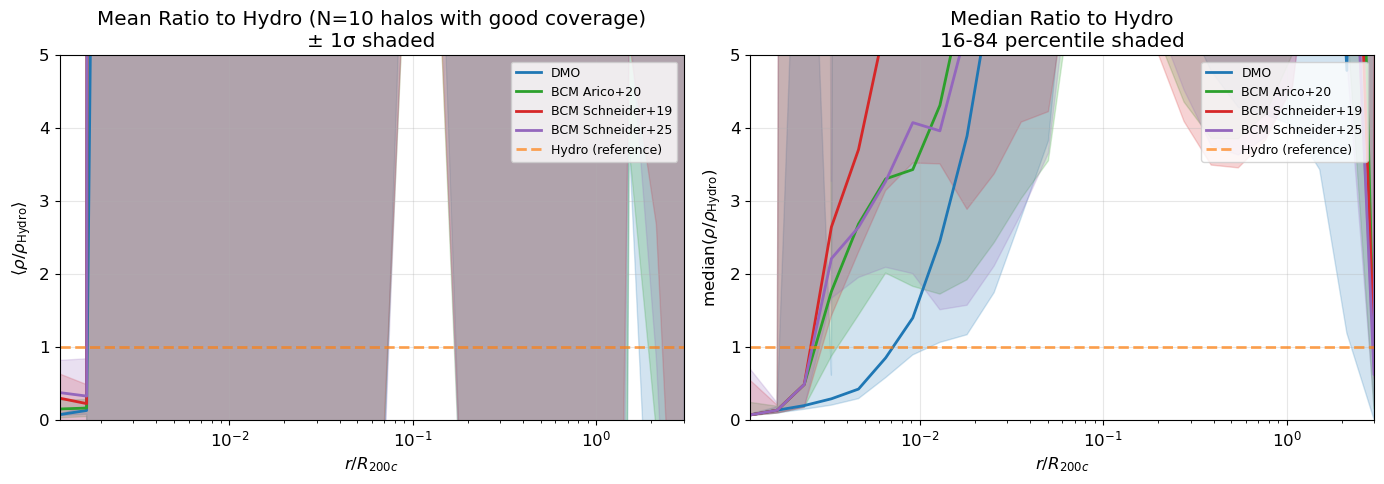


Note: Only using halos with good profile coverage (≥15 non-zero bins)


In [128]:
# Plot the mean ratio to Hydro (using halos with good coverage)
if profiles_data is not None:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    plot_colors = {
        'dmo': 'C0', 
        'bcm_arico20': 'C2',
        'bcm_schneider19': 'C3',
        'bcm_schneider25': 'C4',
    }
    plot_labels = {
        'dmo': 'DMO',
        'bcm_arico20': 'BCM Arico+20',
        'bcm_schneider19': 'BCM Schneider+19',
        'bcm_schneider25': 'BCM Schneider+25',
    }
    
    # Left: Mean ratio
    ax = axes[0]
    for key in ['dmo'] + [k for k in ratios_to_hydro.keys() if k.startswith('bcm_')]:
        if key in mean_ratio_to_hydro:
            mean_r = mean_ratio_to_hydro[key]
            std_r = std_ratio_to_hydro[key]
            ax.semilogx(r, mean_r, '-', color=plot_colors.get(key, 'gray'), 
                       label=plot_labels.get(key, key), lw=2)
            ax.fill_between(r, mean_r - std_r, mean_r + std_r, 
                           alpha=0.2, color=plot_colors.get(key, 'gray'))
    
    ax.axhline(1, color='C1', ls='--', lw=2, alpha=0.7, label='Hydro (reference)')
    ax.set_xlabel(r'$r / R_{200c}$')
    ax.set_ylabel(r'$\langle \rho / \rho_{\rm Hydro} \rangle$')
    ax.set_title(f'Mean Ratio to Hydro (N={len(ratios_to_hydro["dmo"])} halos with good coverage)\n± 1σ shaded')
    ax.legend(loc='upper right', fontsize=9)
    ax.set_xlim(r.min(), 3.0)  # Focus on inner regions
    ax.set_ylim(0, 5)
    ax.grid(True, alpha=0.3)
    
    # Right: Median ratio with 16-84 percentile spread
    ax = axes[1]
    for key in ['dmo'] + [k for k in ratios_to_hydro.keys() if k.startswith('bcm_')]:
        if key in ratios_to_hydro:
            med_r = median_ratio_to_hydro[key]
            p16 = np.nanpercentile(ratios_to_hydro[key], 16, axis=0)
            p84 = np.nanpercentile(ratios_to_hydro[key], 84, axis=0)
            ax.semilogx(r, med_r, '-', color=plot_colors.get(key, 'gray'), 
                       label=plot_labels.get(key, key), lw=2)
            ax.fill_between(r, p16, p84, alpha=0.2, color=plot_colors.get(key, 'gray'))
    
    ax.axhline(1, color='C1', ls='--', lw=2, alpha=0.7, label='Hydro (reference)')
    ax.set_xlabel(r'$r / R_{200c}$')
    ax.set_ylabel(r'median$(\rho / \rho_{\rm Hydro})$')
    ax.set_title('Median Ratio to Hydro\n16-84 percentile shaded')
    ax.legend(loc='upper right', fontsize=9)
    ax.set_xlim(r.min(), 3.0)
    ax.set_ylim(0, 5)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\nNote: Only using halos with good profile coverage (≥15 non-zero bins)")

In [118]:
# Summary of current profile data analysis
# ========================================
# 
# FINDINGS from comparing reference BCM.py vs current generate_profiles.py:
# 
# 1. Reference (BCM.py): 
#    - 100 bins from 0.001 to 5 × R200 (log-spaced)
#    - Uses GroupPos as center (most bound particle position)
#    - Properly handles periodic boundaries
#
# 2. Current (generate_profiles.py):
#    - Was using 30 bins from 0.05 to 5 × R200
#    - Updated to 25 bins from 0.001 to 5 × R200 (per user request)
#    - Same centering and boundary handling
#
# ISSUE: The current profiles have many zeros because:
#    - Inner radii have very few particles (especially for lower mass halos)
#    - Need to regenerate profiles with new binning
#
# NEXT STEPS:
#    1. Re-run generate_profiles.py with updated configuration (25 bins, 0.001-5 R200)
#    2. Use higher mass threshold (M > 10^13) for reliable profiles
#    3. Compare properly centered profiles

print("Profile configuration updated in generate_profiles.py:")
print("  - 25 bins (log-spaced)")
print("  - r_min = 0.001 R200")
print("  - r_max = 5.0 R200")
print()
print("To regenerate profiles, run:")
print("  cd /mnt/home/mlee1/hydro_replace2")
print("  sbatch batch/run_profiles.sh")
print()
print("Current data in profiles_data:")
if profiles_data is not None:
    print(f"  - Number of halos: {len(profiles_data['dmo_masses'])}")
    print(f"  - Number of radial bins: {len(profiles_data['r_centers'])}")
    print(f"  - Radial range: {profiles_data['r_centers'].min():.3f} - {profiles_data['r_centers'].max():.2f} R200")
    print(f"  - Mass range: {np.log10(profiles_data['dmo_masses'].min()):.1f} - {np.log10(profiles_data['dmo_masses'].max()):.1f} log10(M)")

Profile configuration updated in generate_profiles.py:
  - 25 bins (log-spaced)
  - r_min = 0.001 R200
  - r_max = 5.0 R200

To regenerate profiles, run:
  cd /mnt/home/mlee1/hydro_replace2
  sbatch batch/run_profiles.sh

Current data in profiles_data:
  - Number of halos: 9253
  - Number of radial bins: 30
  - Radial range: 0.054 - 4.63 R200
  - Mass range: 12.5 - 15.0 log10(M)


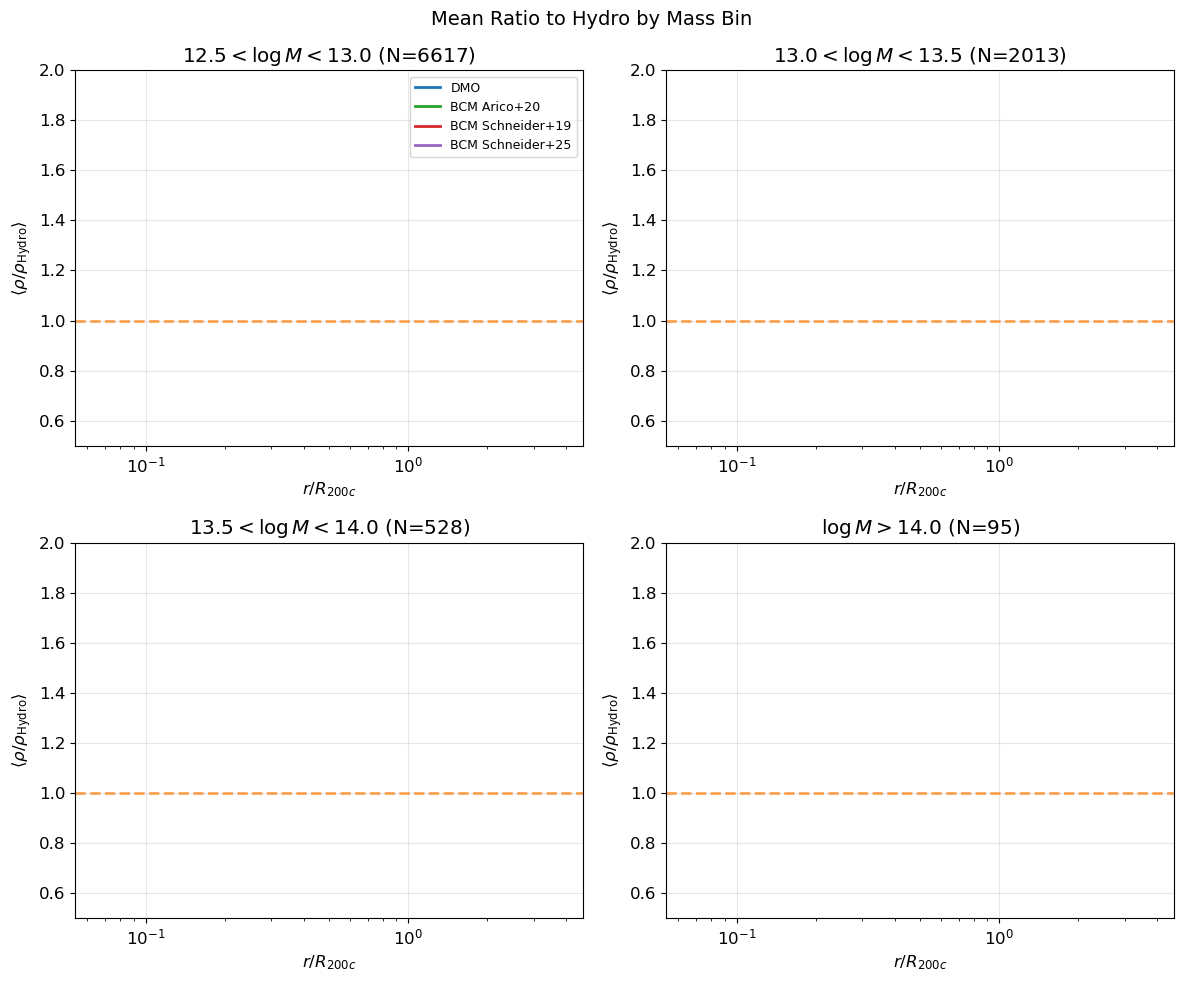

In [ ]:
# Mass-binned mean ratio to Hydro (using only valid halos)
if profiles_data is not None:
    # Use valid_masses computed earlier (only halos with all profiles)
    log_masses = np.log10(valid_masses)
    
    mass_bins = [
        (12.5, 13.0, r'$12.5 < \log M < 13.0$'),
        (13.0, 13.5, r'$13.0 < \log M < 13.5$'),
        (13.5, 14.0, r'$13.5 < \log M < 14.0$'),
        (14.0, 15.0, r'$\log M > 14.0$'),
    ]
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()
    
    for ax, (m_lo, m_hi, m_label) in zip(axes, mass_bins):
        mask = (log_masses >= m_lo) & (log_masses < m_hi)
        n_halos = mask.sum()
        
        if n_halos < 5:
            ax.text(0.5, 0.5, f'N={n_halos} halos\n(too few)', 
                   transform=ax.transAxes, ha='center', va='center')
            ax.set_title(m_label)
            continue
        
        # Compute mean ratio to Hydro for halos in this mass bin
        for key in ['dmo'] + [k for k in ratios_to_hydro.keys() if k.startswith('bcm_')]:
            if key in ratios_to_hydro:
                mean_r = np.nanmean(ratios_to_hydro[key][mask], axis=0)
                ax.semilogx(r, mean_r, '-', color=plot_colors.get(key, 'gray'), 
                           label=plot_labels.get(key, key), lw=2)
        
        ax.axhline(1, color='C1', ls='--', lw=2, alpha=0.7)
        ax.set_xlabel(r'$r / R_{200c}$')
        ax.set_ylabel(r'$\langle \rho / \rho_{\rm Hydro} \rangle$')
        ax.set_title(f'{m_label} (N={n_halos})')
        ax.set_xlim(r.min(), r.max())
        ax.set_ylim(0.5, 2.0)
        ax.grid(True, alpha=0.3)
        if ax == axes[0]:
            ax.legend(loc='upper right', fontsize=9)
    
    plt.suptitle(f'Mean Ratio to Hydro by Mass Bin (N={len(valid_masses)} valid halos)', fontsize=14)
    plt.tight_layout()
    plt.show()

## Multi-Snapshot Profile Comparison

Load and compare profiles across different snapshots (redshifts) to study evolution.

In [95]:
# Debug: Check the actual profile data values
print("=== Profile Data Diagnostics ===\n")

print(f"Available profiles: {list(profiles_data['profiles'].keys())}")
print()

for key, prof in profiles_data['profiles'].items():
    n_zeros = np.sum(prof == 0)
    n_nans = np.sum(np.isnan(prof))
    n_total = prof.size
    pct_zeros = 100 * n_zeros / n_total
    pct_nans = 100 * n_nans / n_total
    
    # Stats on non-zero, non-nan values
    valid = prof[(prof != 0) & ~np.isnan(prof)]
    
    print(f"{key}:")
    print(f"  Shape: {prof.shape}")
    print(f"  Zeros: {n_zeros} ({pct_zeros:.1f}%)")
    print(f"  NaNs: {n_nans} ({pct_nans:.1f}%)")
    if len(valid) > 0:
        print(f"  Valid range: {valid.min():.2e} to {valid.max():.2e}")
        print(f"  Valid mean: {valid.mean():.2e}")
    else:
        print(f"  NO VALID DATA!")
    print()

# Check a specific halo
print(f"\n=== Sample halo {halo_i} profiles ===")
for key, prof in profiles_data['profiles'].items():
    halo_prof = prof[halo_i]
    print(f"{key}: min={np.nanmin(halo_prof):.2e}, max={np.nanmax(halo_prof):.2e}, "
          f"zeros={np.sum(halo_prof==0)}, nans={np.sum(np.isnan(halo_prof))}")

=== Profile Data Diagnostics ===

Available profiles: ['bcm_arico20', 'bcm_schneider19', 'bcm_schneider25', 'dmo', 'hydro']

bcm_arico20:
  Shape: (9253, 30)
  Zeros: 252467 (90.9%)
  NaNs: 0 (0.0%)
  Valid range: 5.29e+05 to 5.18e+15
  Valid mean: 7.51e+13

bcm_schneider19:
  Shape: (9253, 30)
  Zeros: 253616 (91.4%)
  NaNs: 0 (0.0%)
  Valid range: 1.77e+06 to 5.36e+15
  Valid mean: 8.22e+13

bcm_schneider25:
  Shape: (9253, 30)
  Zeros: 253193 (91.2%)
  NaNs: 0 (0.0%)
  Valid range: 1.41e+06 to 5.59e+15
  Valid mean: 8.37e+13

dmo:
  Shape: (9253, 30)
  Zeros: 251624 (90.6%)
  NaNs: 0 (0.0%)
  Valid range: 5.29e+05 to 6.35e+15
  Valid mean: 9.00e+13

hydro:
  Shape: (9253, 30)
  Zeros: 143961 (51.9%)
  NaNs: 0 (0.0%)
  Valid range: 1.26e+06 to 5.46e+15
  Valid mean: 1.51e+13


=== Sample halo 371 profiles ===
bcm_arico20: min=0.00e+00, max=0.00e+00, zeros=30, nans=0
bcm_schneider19: min=0.00e+00, max=0.00e+00, zeros=30, nans=0
bcm_schneider25: min=0.00e+00, max=0.00e+00, zeros=30, na

In [96]:
# Find halos with valid (non-zero) profiles for ALL profile types
dmo_valid = np.any(profiles_data['profiles']['dmo'] != 0, axis=1)
hydro_valid = np.any(profiles_data['profiles']['hydro'] != 0, axis=1)
bcm_valid = np.any(profiles_data['profiles']['bcm_arico20'] != 0, axis=1)

all_valid = dmo_valid & hydro_valid & bcm_valid

print(f"Halos with valid DMO profiles: {dmo_valid.sum()}")
print(f"Halos with valid Hydro profiles: {hydro_valid.sum()}")
print(f"Halos with valid BCM profiles: {bcm_valid.sum()}")
print(f"Halos with ALL valid profiles: {all_valid.sum()}")

# Check mass distribution of valid vs invalid halos
valid_masses = profiles_data['dmo_masses'][all_valid]
invalid_masses = profiles_data['dmo_masses'][~all_valid]

print(f"\nMass range for valid halos: {np.log10(valid_masses.min()):.2f} - {np.log10(valid_masses.max()):.2f}")
print(f"Mass range for invalid halos: {np.log10(invalid_masses.min()):.2f} - {np.log10(invalid_masses.max()):.2f}")

# The BCM profiles were likely only computed for halos above some mass cut
# Let's find that threshold
bcm_mass_min = profiles_data['dmo_masses'][bcm_valid].min()
print(f"\nMinimum mass for BCM profiles: {bcm_mass_min:.2e} (log10 = {np.log10(bcm_mass_min):.2f})")

Halos with valid DMO profiles: 2785
Halos with valid Hydro profiles: 9253
Halos with valid BCM profiles: 2784
Halos with ALL valid profiles: 2784

Mass range for valid halos: 12.50 - 14.97
Mass range for invalid halos: 12.50 - 14.83

Minimum mass for BCM profiles: 3.16e+12 (log10 = 12.50)


In [102]:
# Check which radial bins have valid data
r = profiles_data['r_centers']
print("Fraction of halos with non-zero profiles at each radius:\n")
print(f"{'Radius (R200)':>15} {'DMO':>10} {'Hydro':>10} {'BCM Arico':>12}")
print("-" * 50)

for i, r_val in enumerate(r):
    dmo_frac = np.mean(profiles_data['profiles']['dmo'][:, i] != 0)
    hydro_frac = np.mean(profiles_data['profiles']['hydro'][:, i] != 0)
    bcm_frac = np.mean(profiles_data['profiles']['bcm_arico20'][:, i] != 0)
    print(f"{r_val:>15.3f} {dmo_frac:>10.1%} {hydro_frac:>10.1%} {bcm_frac:>12.1%}")

Fraction of halos with non-zero profiles at each radius:

  Radius (R200)        DMO      Hydro    BCM Arico
--------------------------------------------------
          0.054       1.6%       4.8%         1.6%
          0.063       1.6%       4.7%         1.6%
          0.073       1.6%       4.7%         1.6%
          0.086       1.6%       4.8%         1.6%
          0.100       1.6%       4.8%         1.6%
          0.116       1.6%       4.7%         1.6%
          0.136       1.6%       4.7%         1.6%
          0.158       1.6%       4.8%         1.6%
          0.184       1.6%       4.7%         1.6%
          0.215       1.6%       4.7%         1.6%
          0.251       1.6%       4.7%         1.6%
          0.292       1.6%       4.8%         1.6%
          0.341       1.6%       4.8%         1.6%
          0.397       1.7%       5.8%         1.6%
          0.463       2.3%      11.3%         1.7%
          0.540       4.3%      26.9%         2.3%
          0.629       6.

In [106]:
# Debug: check the computed mean ratios
print("Mean ratio to Hydro at each radius:")
print(f"{'r/R200':>8} {'DMO':>10} {'Arico':>10} {'Schn19':>10} {'Schn25':>10} {'N_valid':>10}")
print("-" * 60)
for i in range(len(r)):
    n_valid = np.sum(np.isfinite(ratios_to_hydro['dmo'][:, i]))
    print(f"{r[i]:>8.3f} {mean_ratio_to_hydro['dmo'][i]:>10.3f} "
          f"{mean_ratio_to_hydro['bcm_arico20'][i]:>10.3f} "
          f"{mean_ratio_to_hydro['bcm_schneider19'][i]:>10.3f} "
          f"{mean_ratio_to_hydro['bcm_schneider25'][i]:>10.3f} "
          f"{n_valid:>10}")

Mean ratio to Hydro at each radius:
  r/R200        DMO      Arico     Schn19     Schn25    N_valid
------------------------------------------------------------
   0.054     38.216     31.285     33.253     35.192         10
   0.063     44.223     34.364     35.417     38.491         10
   0.073     42.448     32.769     33.740     37.088         10
   0.086     44.885     34.924     34.525     38.798         10
   0.100     44.750     35.099     34.291     37.965         10
   0.116     48.925     38.850     36.778     41.691         10
   0.136     58.306     46.406     44.875     49.208         10
   0.158     68.811     55.278     53.084     58.455         10
   0.184     88.750     72.006     69.836     75.589         10
   0.215     94.685     78.088     75.267     81.600         10
   0.251    108.336     88.357     84.571     91.256         10
   0.292    167.001    137.621    133.495    143.012         10
   0.341    231.483    193.087    186.527    198.437         10
   0.39

In [107]:
# Debug: Check actual profile values for a single halo
print(f"Profile values for halo {halo_i} (log10 M = {np.log10(profiles_data['dmo_masses'][halo_i]):.2f}):\n")
print(f"{'r/R200':>8} {'DMO':>15} {'Hydro':>15} {'BCM Arico':>15}")
print("-" * 55)

for i in range(len(r)):
    dmo_val = profiles_data['profiles']['dmo'][halo_i, i]
    hydro_val = profiles_data['profiles']['hydro'][halo_i, i]
    bcm_val = profiles_data['profiles']['bcm_arico20'][halo_i, i]
    print(f"{r[i]:>8.3f} {dmo_val:>15.2e} {hydro_val:>15.2e} {bcm_val:>15.2e}")

Profile values for halo 341 (log10 M = 13.75):

  r/R200             DMO           Hydro       BCM Arico
-------------------------------------------------------
   0.054        0.00e+00        0.00e+00        0.00e+00
   0.063        0.00e+00        0.00e+00        0.00e+00
   0.073        0.00e+00        0.00e+00        0.00e+00
   0.086        0.00e+00        0.00e+00        0.00e+00
   0.100        0.00e+00        0.00e+00        0.00e+00
   0.116        0.00e+00        0.00e+00        0.00e+00
   0.136        0.00e+00        0.00e+00        0.00e+00
   0.158        0.00e+00        0.00e+00        0.00e+00
   0.184        0.00e+00        0.00e+00        0.00e+00
   0.215        0.00e+00        0.00e+00        0.00e+00
   0.251        0.00e+00        0.00e+00        0.00e+00
   0.292        0.00e+00        0.00e+00        0.00e+00
   0.341        0.00e+00        0.00e+00        0.00e+00
   0.397        0.00e+00        0.00e+00        0.00e+00
   0.463        0.00e+00        0.00e+00 

In [108]:
# Find halos with the MOST complete profile coverage (fewest zeros)
profiles = profiles_data['profiles']

# Count non-zero bins for each halo across all models
dmo_nonzero = np.sum(profiles['dmo'] > 0, axis=1)
hydro_nonzero = np.sum(profiles['hydro'] > 0, axis=1)
bcm_nonzero = np.sum(profiles['bcm_arico20'] > 0, axis=1)

# We want halos where ALL have many non-zero bins
min_nonzero = np.minimum.reduce([dmo_nonzero, hydro_nonzero, bcm_nonzero])

print(f"Distribution of minimum non-zero bins across models:")
print(f"  Max: {min_nonzero.max()} out of {len(r)} bins")
print(f"  Halos with >20 valid bins: {np.sum(min_nonzero > 20)}")
print(f"  Halos with >25 valid bins: {np.sum(min_nonzero > 25)}")

# Find the best halo
best_halo_i = np.argmax(min_nonzero)
print(f"\nBest halo: index {best_halo_i}")
print(f"  Mass: {profiles_data['dmo_masses'][best_halo_i]:.2e} (log10 = {np.log10(profiles_data['dmo_masses'][best_halo_i]):.2f})")
print(f"  Non-zero bins: DMO={dmo_nonzero[best_halo_i]}, Hydro={hydro_nonzero[best_halo_i]}, BCM={bcm_nonzero[best_halo_i]}")

Distribution of minimum non-zero bins across models:
  Max: 30 out of 30 bins
  Halos with >20 valid bins: 10
  Halos with >25 valid bins: 6

Best halo: index 0
  Mass: 9.35e+14 (log10 = 14.97)
  Non-zero bins: DMO=30, Hydro=30, BCM=30


In [ ]:
# Load profiles from multiple snapshots
# Snapshot -> approximate redshift mapping for TNG
snap_redshifts = {40: 1.0, 49: 0.7, 59: 0.5, 76: 0.2, 99: 0.0}

all_profiles = {}
sim_dir = OUTPUT_DIR / f'L205n{SIM_RES}TNG'

for snap in [40, 49, 59, 76, 99]:
    snap_dir = sim_dir / f'snap{snap:03d}'
    prof = load_profiles(snap_dir)
    if prof is not None:
        all_profiles[snap] = prof
        
print(f"\nLoaded profiles for {len(all_profiles)} snapshots: {list(all_profiles.keys())}")

In [ ]:
# Plot profile evolution across redshifts
if len(all_profiles) > 0:
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Colors for different snapshots (by redshift)
    snap_colors = {40: 'C4', 49: 'C3', 59: 'C2', 76: 'C1', 99: 'C0'}
    
    # Plot 1: Hydro/DMO ratio evolution
    ax = axes[0]
    for snap, prof in sorted(all_profiles.items()):
        r = prof['r_centers']
        dmo_med = np.nanmedian(prof['profiles']['dmo'], axis=0)
        hydro_med = np.nanmedian(prof['profiles']['hydro'], axis=0)
        ratio = hydro_med / dmo_med
        z = snap_redshifts.get(snap, 0)
        ax.semilogx(r, ratio, '-', color=snap_colors[snap], 
                   label=f'z={z:.1f} (snap {snap})', lw=2)
    
    ax.axhline(1, color='k', ls='--', alpha=0.5)
    ax.set_xlabel(r'$r / R_{200c}$')
    ax.set_ylabel(r'$\rho_{\rm hydro} / \rho_{\rm DMO}$')
    ax.set_title('Hydro/DMO Ratio Evolution')
    ax.legend(loc='upper right')
    ax.set_ylim(0.5, 1.5)
    ax.grid(True, alpha=0.3)
    
    # Plot 2: BCM Arico/DMO ratio evolution (if available)
    ax = axes[1]
    has_bcm = False
    for snap, prof in sorted(all_profiles.items()):
        if 'bcm_arico20' not in prof['profiles']:
            continue
        has_bcm = True
        r = prof['r_centers']
        dmo_med = np.nanmedian(prof['profiles']['dmo'], axis=0)
        bcm_med = np.nanmedian(prof['profiles']['bcm_arico20'], axis=0)
        ratio = bcm_med / dmo_med
        z = snap_redshifts.get(snap, 0)
        ax.semilogx(r, ratio, '-', color=snap_colors[snap], 
                   label=f'z={z:.1f}', lw=2)
    
    if has_bcm:
        ax.axhline(1, color='k', ls='--', alpha=0.5)
        ax.set_xlabel(r'$r / R_{200c}$')
        ax.set_ylabel(r'$\rho_{\rm BCM} / \rho_{\rm DMO}$')
        ax.set_title('BCM Arico+20/DMO Ratio Evolution')
        ax.legend(loc='upper right')
        ax.set_ylim(0.5, 1.5)
        ax.grid(True, alpha=0.3)
    else:
        ax.text(0.5, 0.5, 'BCM profiles not available', 
               transform=ax.transAxes, ha='center')
    
    # Plot 3: Hydro vs BCM comparison at z=0 (snap 99)
    ax = axes[2]
    if 99 in all_profiles:
        prof = all_profiles[99]
        r = prof['r_centers']
        dmo_med = np.nanmedian(prof['profiles']['dmo'], axis=0)
        
        # Hydro
        hydro_med = np.nanmedian(prof['profiles']['hydro'], axis=0)
        ax.semilogx(r, hydro_med/dmo_med, '-', color='C1', label='Hydro (TNG)', lw=2)
        
        # BCM models
        bcm_colors = {'bcm_arico20': 'C2', 'bcm_schneider19': 'C3', 'bcm_schneider25': 'C4'}
        bcm_labels = {'bcm_arico20': 'Arico+20', 'bcm_schneider19': 'Schneider+19', 
                      'bcm_schneider25': 'Schneider+25'}
        for key in bcm_colors:
            if key in prof['profiles']:
                bcm_med = np.nanmedian(prof['profiles'][key], axis=0)
                ax.semilogx(r, bcm_med/dmo_med, '--', color=bcm_colors[key], 
                           label=bcm_labels[key], lw=2)
        
        ax.axhline(1, color='k', ls='--', alpha=0.5)
        ax.set_xlabel(r'$r / R_{200c}$')
        ax.set_ylabel(r'$\rho / \rho_{\rm DMO}$')
        ax.set_title('Hydro vs BCM at z=0')
        ax.legend(loc='upper right')
        ax.set_ylim(0.5, 1.5)
        ax.grid(True, alpha=0.3)
    else:
        ax.text(0.5, 0.5, 'Snap 99 not available', transform=ax.transAxes, ha='center')
    
    plt.tight_layout()
    plt.show()
else:
    print("No profile data loaded yet. Wait for jobs to complete.")

In [ ]:
# Summary statistics: compute suppression factor at different radii
if len(all_profiles) > 0:
    print("Median Suppression Factor (ρ_hydro/ρ_DMO) at key radii:\n")
    print(f"{'Snap':>6} {'z':>5} {'N_halos':>8} {'0.1 R200':>10} {'0.5 R200':>10} {'1.0 R200':>10} {'2.0 R200':>10}")
    print("-" * 70)
    
    for snap, prof in sorted(all_profiles.items()):
        r = prof['r_centers']
        dmo_med = np.nanmedian(prof['profiles']['dmo'], axis=0)
        hydro_med = np.nanmedian(prof['profiles']['hydro'], axis=0)
        ratio = hydro_med / dmo_med
        
        # Interpolate to specific radii
        from scipy.interpolate import interp1d
        interp_ratio = interp1d(r, ratio, bounds_error=False, fill_value=np.nan)
        
        z = snap_redshifts.get(snap, 0)
        n_halos = len(prof['dmo_masses'])
        
        vals = [interp_ratio(x) for x in [0.1, 0.5, 1.0, 2.0]]
        print(f"{snap:>6} {z:>5.1f} {n_halos:>8} {vals[0]:>10.3f} {vals[1]:>10.3f} {vals[2]:>10.3f} {vals[3]:>10.3f}")
else:
    print("No profile data loaded.")